In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.image import central_crop, pad_to_bounding_box, resize
from tensorflow.keras.models import Model

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.4 
session = tf.compat.v1.Session(config=config)

In [7]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15926698135868092185
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1073741824
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4142727621472047556
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [8]:
df = pd.read_excel('data_file/여행지 라벨.xlsx')
df

나라          관광지                  en나라                 en관광지   유형  \
0       미국     그리피스 천문대               America  Griffith Observatory  건축물   
1       미국      자유의 여신상               America     Statue of Liberty  조형물   
2       호주  시드니 오페라 하우스             Australia    Sydney Opera House  건축물   
3      브라질      브라질 예수상                Brazil             Corcovado  조형물   
4      브라질       셀라론 계단                Brazil     Escadaria Selaron  조형물   
..     ...          ...                   ...                   ...  ...   
75      태국      에메랄드 사원              Thailand         Wat Phra Kaew   유적   
76      터키  술탄 아흐메트 모스크                Turkey           Blue Mosque  건축물   
77      터키    예레바탄 지하궁전                Turkey      Basilica Cistern   유적   
78      터키    하드리아누스의 문                Turkey        Hadrian's Gate   유적   
79  아랍에미리트      부르즈 할리파  United Arab Emirates          Burj Khalifa  건축물   

   Unnamed: 5  
0         NaN  
1         NaN  
2        랜드마크  
3        랜드마크  
4        랜드마크  
..        ...  
75         성지  
76         성지  
77       역사유적  
78       고대유적  
79       전망시설  

[80 rows x 6 columns]

In [9]:
train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                 rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode='nearest')
validataion_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
#classes_li = list(df['en관광지'][:10].values)
target_size = (150, 150)
batch_size = 30
train_generator = train_datagen.flow_from_directory('country_img_gen/train', target_size = target_size, batch_size = batch_size)
validataion_generator = validataion_datagen.flow_from_directory('country_img_gen/validation', target_size = target_size, batch_size = batch_size)
test_generator = test_datagen.flow_from_directory('country_img_gen/test/', target_size = target_size, batch_size = batch_size)

Found 17871 images belonging to 13 classes.
Found 5957 images belonging to 13 classes.
Found 5957 images belonging to 13 classes.


In [11]:
#classes_li = list(df['en관광지'][:10].values)
target_size = (150, 150)
batch_size = 30
train_generator = train_datagen.flow_from_directory('tour_img_gen/train', target_size = target_size, batch_size = batch_size)
validataion_generator = validataion_datagen.flow_from_directory('tour_img_gen/validation', target_size = target_size, batch_size = batch_size)
test_generator = test_datagen.flow_from_directory('tour_img_gen/test/', target_size = target_size, batch_size = batch_size)

Found 17871 images belonging to 47 classes.
Found 5957 images belonging to 47 classes.
Found 5957 images belonging to 47 classes.


In [12]:
# print(17871   / batch_size)
# print(5957  / batch_size)

In [13]:
for x_data, y_data in train_generator:
    print(x_data.shape)  # (20, 150, 150, 3)
    print(type(x_data))  # <class 'numpy.ndarray'>
    print(y_data)
    break

(30, 150, 150, 3)
<class 'numpy.ndarray'>
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


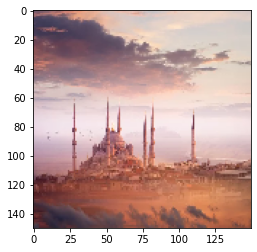

In [22]:
plt.imshow(x_data[0])

In [53]:
df[['en나라', 'en관광지']][-1:].values

array([['United Arab Emirates', 'Burj Khalifa']], dtype=object)

In [9]:
tour_name = 'Burj Khalifa'
path = f"img/United Arab Emirates/{tour_name}/"
names = os.listdir(path)

for i, name in enumerate(names):
    old_name = path + name
    new_name = path + tour_name + str(i) + ".jpg"
    #print(old_name, new_name)
    os.rename(old_name, new_name)
    
names = os.listdir(path)    
for i, name in enumerate(names):
    old_name = path + name
    new_name = path + str(i) + ".jpg"
    #print(old_name, new_name)
    os.rename(old_name, new_name)

In [92]:
df[df['en관광지'] == 'Penang temple']

나라   관광지      en나라          en관광지   유형 Unnamed: 5
55  말레이시아  쿠 콩시  Malaysia  Penang temple  건축물        NaN

In [16]:
x = []
y = []
size = (256, 256)
datas = df[['en나라', 'en관광지']].values
for data in datas:
    country = data[0]
    tour = data[1]
    for i in range(100):
        path = f"img/{country}/{tour}/{i}.jpg"
        img = load_img(path)
        img_array = img_to_array(img) / 255
        img_resize = resize(img_array, size)
        x.append(np.array(img_resize))
        y.append(tour)
    print(f"{tour} transform Successful")
x = np.array(x)

FileNotFoundError: [Errno 2] No such file or directory: 'img/Greece/Temple of Olympian Zeus/64.jpg'

In [8]:
df = pd.read_excel('data_file/나라별 여행지 라벨.xlsx')
x = []
y = []
size = (256, 256)
datas = df[['en나라', 'en관광지']].values
for data in datas:
    country = data[0]
    tour = data[1]
    path = f'country_img/{country}'
    name_li = os.listdir(path)
    for name in name_li:
        if tour in name:
            print(name, 'transform')
            img = load_img(f"{path}/{name}")
            img_array = img_to_array(img) / 255
            img_resize = resize(img_array, size)
            x.append(np.array(img_resize))
            y.append(country)
    print(f"{country} {tour} transform Successful")

Temple of Olympian Zeus0.jpg transform
Temple of Olympian Zeus1.jpg transform
Temple of Olympian Zeus10.jpg transform
Temple of Olympian Zeus100.jpg transform
Temple of Olympian Zeus101.jpg transform
Temple of Olympian Zeus102.jpg transform
Temple of Olympian Zeus103.jpg transform
Temple of Olympian Zeus104.jpg transform
Temple of Olympian Zeus105.jpg transform
Temple of Olympian Zeus106.jpg transform
Temple of Olympian Zeus107.jpg transform
Temple of Olympian Zeus108.jpg transform
Temple of Olympian Zeus109.jpg transform
Temple of Olympian Zeus11.jpg transform
Temple of Olympian Zeus110.jpg transform
Temple of Olympian Zeus111.jpg transform
Temple of Olympian Zeus112.jpg transform
Temple of Olympian Zeus113.jpg transform
Temple of Olympian Zeus114.jpg transform
Temple of Olympian Zeus115.jpg transform
Temple of Olympian Zeus116.jpg transform
Temple of Olympian Zeus117.jpg transform
Temple of Olympian Zeus118.jpg transform
Temple of Olympian Zeus119.jpg transform
Temple of Olympian Zeu

Temple of Olympian Zeus288.jpg transform
Temple of Olympian Zeus289.jpg transform
Temple of Olympian Zeus29.jpg transform
Temple of Olympian Zeus290.jpg transform
Temple of Olympian Zeus291.jpg transform
Temple of Olympian Zeus292.jpg transform
Temple of Olympian Zeus293.jpg transform
Temple of Olympian Zeus294.jpg transform
Temple of Olympian Zeus295.jpg transform
Temple of Olympian Zeus296.jpg transform
Temple of Olympian Zeus297.jpg transform
Temple of Olympian Zeus298.jpg transform
Temple of Olympian Zeus299.jpg transform
Temple of Olympian Zeus3.jpg transform
Temple of Olympian Zeus30.jpg transform
Temple of Olympian Zeus300.jpg transform
Temple of Olympian Zeus301.jpg transform
Temple of Olympian Zeus302.jpg transform
Temple of Olympian Zeus303.jpg transform
Temple of Olympian Zeus304.jpg transform
Temple of Olympian Zeus305.jpg transform
Temple of Olympian Zeus306.jpg transform
Temple of Olympian Zeus307.jpg transform
Temple of Olympian Zeus308.jpg transform
Temple of Olympian Z

Temple of Olympian Zeus469.jpg transform
Temple of Olympian Zeus47.jpg transform
Temple of Olympian Zeus470.jpg transform
Temple of Olympian Zeus471.jpg transform
Temple of Olympian Zeus472.jpg transform
Temple of Olympian Zeus473.jpg transform
Temple of Olympian Zeus474.jpg transform
Temple of Olympian Zeus475.jpg transform
Temple of Olympian Zeus476.jpg transform
Temple of Olympian Zeus477.jpg transform
Temple of Olympian Zeus478.jpg transform
Temple of Olympian Zeus479.jpg transform
Temple of Olympian Zeus48.jpg transform
Temple of Olympian Zeus480.jpg transform
Temple of Olympian Zeus481.jpg transform
Temple of Olympian Zeus482.jpg transform
Temple of Olympian Zeus483.jpg transform
Temple of Olympian Zeus484.jpg transform
Temple of Olympian Zeus485.jpg transform
Temple of Olympian Zeus486.jpg transform
Temple of Olympian Zeus487.jpg transform
Temple of Olympian Zeus488.jpg transform
Temple of Olympian Zeus489.jpg transform
Temple of Olympian Zeus49.jpg transform
Temple of Olympian 

Temple of Olympian Zeus652.jpg transform
Temple of Olympian Zeus653.jpg transform
Temple of Olympian Zeus654.jpg transform
Temple of Olympian Zeus655.jpg transform
Temple of Olympian Zeus656.jpg transform
Temple of Olympian Zeus657.jpg transform
Temple of Olympian Zeus658.jpg transform
Temple of Olympian Zeus659.jpg transform
Temple of Olympian Zeus66.jpg transform
Temple of Olympian Zeus660.jpg transform
Temple of Olympian Zeus661.jpg transform
Temple of Olympian Zeus662.jpg transform
Temple of Olympian Zeus663.jpg transform
Temple of Olympian Zeus664.jpg transform
Temple of Olympian Zeus665.jpg transform
Temple of Olympian Zeus666.jpg transform
Temple of Olympian Zeus667.jpg transform
Temple of Olympian Zeus668.jpg transform
Temple of Olympian Zeus669.jpg transform
Temple of Olympian Zeus67.jpg transform
Temple of Olympian Zeus670.jpg transform
Temple of Olympian Zeus671.jpg transform
Temple of Olympian Zeus672.jpg transform
Temple of Olympian Zeus673.jpg transform
Temple of Olympian

Temple of Olympian Zeus842.jpg transform
Temple of Olympian Zeus843.jpg transform
Temple of Olympian Zeus844.jpg transform
Temple of Olympian Zeus845.jpg transform
Temple of Olympian Zeus846.jpg transform
Temple of Olympian Zeus847.jpg transform
Temple of Olympian Zeus848.jpg transform
Temple of Olympian Zeus849.jpg transform
Temple of Olympian Zeus85.jpg transform
Temple of Olympian Zeus850.jpg transform
Temple of Olympian Zeus851.jpg transform
Temple of Olympian Zeus852.jpg transform
Temple of Olympian Zeus853.jpg transform
Temple of Olympian Zeus854.jpg transform
Temple of Olympian Zeus855.jpg transform
Temple of Olympian Zeus856.jpg transform
Temple of Olympian Zeus857.jpg transform
Temple of Olympian Zeus858.jpg transform
Temple of Olympian Zeus859.jpg transform
Temple of Olympian Zeus86.jpg transform
Temple of Olympian Zeus860.jpg transform
Temple of Olympian Zeus861.jpg transform
Temple of Olympian Zeus862.jpg transform
Temple of Olympian Zeus863.jpg transform
Temple of Olympian

Ancient Agora of Athens210.jpg transform
Ancient Agora of Athens211.jpg transform
Ancient Agora of Athens212.jpg transform
Ancient Agora of Athens213.jpg transform
Ancient Agora of Athens214.jpg transform
Ancient Agora of Athens215.jpg transform
Ancient Agora of Athens216.jpg transform
Ancient Agora of Athens217.jpg transform
Ancient Agora of Athens218.jpg transform
Ancient Agora of Athens219.jpg transform
Ancient Agora of Athens22.jpg transform
Ancient Agora of Athens220.jpg transform
Ancient Agora of Athens221.jpg transform
Ancient Agora of Athens222.jpg transform
Ancient Agora of Athens223.jpg transform
Ancient Agora of Athens224.jpg transform
Ancient Agora of Athens225.jpg transform
Ancient Agora of Athens226.jpg transform
Ancient Agora of Athens227.jpg transform
Ancient Agora of Athens228.jpg transform
Ancient Agora of Athens229.jpg transform
Ancient Agora of Athens23.jpg transform
Ancient Agora of Athens230.jpg transform
Ancient Agora of Athens231.jpg transform
Ancient Agora of A

Ancient Agora of Athens85.jpg transform
Ancient Agora of Athens86.jpg transform
Ancient Agora of Athens87.jpg transform
Ancient Agora of Athens88.jpg transform
Ancient Agora of Athens89.jpg transform
Ancient Agora of Athens9.jpg transform
Ancient Agora of Athens90.jpg transform
Ancient Agora of Athens91.jpg transform
Ancient Agora of Athens92.jpg transform
Ancient Agora of Athens93.jpg transform
Ancient Agora of Athens94.jpg transform
Ancient Agora of Athens95.jpg transform
Ancient Agora of Athens96.jpg transform
Ancient Agora of Athens97.jpg transform
Ancient Agora of Athens98.jpg transform
Ancient Agora of Athens99.jpg transform
Greece Ancient Agora of Athens transform Successful
Santorini0.jpg transform
Santorini1.jpg transform
Santorini10.jpg transform
Santorini100.jpg transform
Santorini1000.jpg transform
Santorini1001.jpg transform
Santorini1002.jpg transform
Santorini1003.jpg transform
Santorini1004.jpg transform
Santorini1005.jpg transform
Santorini1006.jpg transform
Santorini1

Santorini1243.jpg transform
Santorini1244.jpg transform
Santorini1245.jpg transform
Santorini1246.jpg transform
Santorini1247.jpg transform
Santorini1248.jpg transform
Santorini1249.jpg transform
Santorini125.jpg transform
Santorini1250.jpg transform
Santorini1251.jpg transform
Santorini1252.jpg transform
Santorini1253.jpg transform
Santorini1254.jpg transform
Santorini1255.jpg transform
Santorini1256.jpg transform
Santorini1257.jpg transform
Santorini1258.jpg transform
Santorini1259.jpg transform
Santorini126.jpg transform
Santorini1260.jpg transform
Santorini1261.jpg transform
Santorini1262.jpg transform
Santorini1263.jpg transform
Santorini1264.jpg transform
Santorini1265.jpg transform
Santorini1266.jpg transform
Santorini1267.jpg transform
Santorini1268.jpg transform
Santorini1269.jpg transform
Santorini127.jpg transform
Santorini1270.jpg transform
Santorini1271.jpg transform
Santorini1272.jpg transform
Santorini1273.jpg transform
Santorini1274.jpg transform
Santorini1275.jpg trans

Santorini240.jpg transform
Santorini241.jpg transform
Santorini242.jpg transform
Santorini243.jpg transform
Santorini244.jpg transform
Santorini245.jpg transform
Santorini246.jpg transform
Santorini247.jpg transform
Santorini248.jpg transform
Santorini249.jpg transform
Santorini25.jpg transform
Santorini250.jpg transform
Santorini251.jpg transform
Santorini252.jpg transform
Santorini253.jpg transform
Santorini254.jpg transform
Santorini255.jpg transform
Santorini256.jpg transform
Santorini257.jpg transform
Santorini258.jpg transform
Santorini259.jpg transform
Santorini26.jpg transform
Santorini260.jpg transform
Santorini261.jpg transform
Santorini262.jpg transform
Santorini263.jpg transform
Santorini264.jpg transform
Santorini265.jpg transform
Santorini266.jpg transform
Santorini267.jpg transform
Santorini268.jpg transform
Santorini269.jpg transform
Santorini27.jpg transform
Santorini270.jpg transform
Santorini271.jpg transform
Santorini272.jpg transform
Santorini273.jpg transform
Sant

Santorini515.jpg transform
Santorini516.jpg transform
Santorini517.jpg transform
Santorini518.jpg transform
Santorini519.jpg transform
Santorini52.jpg transform
Santorini520.jpg transform
Santorini521.jpg transform
Santorini522.jpg transform
Santorini523.jpg transform
Santorini524.jpg transform
Santorini525.jpg transform
Santorini526.jpg transform
Santorini527.jpg transform
Santorini528.jpg transform
Santorini529.jpg transform
Santorini53.jpg transform
Santorini530.jpg transform
Santorini531.jpg transform
Santorini532.jpg transform
Santorini533.jpg transform
Santorini534.jpg transform
Santorini535.jpg transform
Santorini536.jpg transform
Santorini537.jpg transform
Santorini538.jpg transform
Santorini539.jpg transform
Santorini54.jpg transform
Santorini540.jpg transform
Santorini541.jpg transform
Santorini542.jpg transform
Santorini543.jpg transform
Santorini544.jpg transform
Santorini545.jpg transform
Santorini546.jpg transform
Santorini547.jpg transform
Santorini548.jpg transform
Sant

Santorini797.jpg transform
Santorini798.jpg transform
Santorini799.jpg transform
Santorini8.jpg transform
Santorini80.jpg transform
Santorini800.jpg transform
Santorini801.jpg transform
Santorini802.jpg transform
Santorini803.jpg transform
Santorini804.jpg transform
Santorini805.jpg transform
Santorini806.jpg transform
Santorini807.jpg transform
Santorini808.jpg transform
Santorini809.jpg transform
Santorini81.jpg transform
Santorini810.jpg transform
Santorini811.jpg transform
Santorini812.jpg transform
Santorini813.jpg transform
Santorini814.jpg transform
Santorini815.jpg transform
Santorini816.jpg transform
Santorini817.jpg transform
Santorini818.jpg transform
Santorini819.jpg transform
Santorini82.jpg transform
Santorini820.jpg transform
Santorini821.jpg transform
Santorini822.jpg transform
Santorini823.jpg transform
Santorini824.jpg transform
Santorini825.jpg transform
Santorini826.jpg transform
Santorini827.jpg transform
Santorini828.jpg transform
Santorini829.jpg transform
Santor

Neuschwanstein160.jpg transform
Neuschwanstein161.jpg transform
Neuschwanstein162.jpg transform
Neuschwanstein163.jpg transform
Neuschwanstein164.jpg transform
Neuschwanstein165.jpg transform
Neuschwanstein166.jpg transform
Neuschwanstein167.jpg transform
Neuschwanstein168.jpg transform
Neuschwanstein169.jpg transform
Neuschwanstein17.jpg transform
Neuschwanstein170.jpg transform
Neuschwanstein171.jpg transform
Neuschwanstein172.jpg transform
Neuschwanstein173.jpg transform
Neuschwanstein174.jpg transform
Neuschwanstein175.jpg transform
Neuschwanstein176.jpg transform
Neuschwanstein177.jpg transform
Neuschwanstein178.jpg transform
Neuschwanstein179.jpg transform
Neuschwanstein18.jpg transform
Neuschwanstein180.jpg transform
Neuschwanstein181.jpg transform
Neuschwanstein182.jpg transform
Neuschwanstein183.jpg transform
Neuschwanstein184.jpg transform
Neuschwanstein185.jpg transform
Neuschwanstein186.jpg transform
Neuschwanstein187.jpg transform
Neuschwanstein188.jpg transform
Neuschwans

Neuschwanstein40.jpg transform
Neuschwanstein400.jpg transform
Neuschwanstein401.jpg transform
Neuschwanstein402.jpg transform
Neuschwanstein403.jpg transform
Neuschwanstein404.jpg transform
Neuschwanstein405.jpg transform
Neuschwanstein406.jpg transform
Neuschwanstein407.jpg transform
Neuschwanstein408.jpg transform
Neuschwanstein409.jpg transform
Neuschwanstein41.jpg transform
Neuschwanstein410.jpg transform
Neuschwanstein411.jpg transform
Neuschwanstein412.jpg transform
Neuschwanstein413.jpg transform
Neuschwanstein414.jpg transform
Neuschwanstein415.jpg transform
Neuschwanstein416.jpg transform
Neuschwanstein417.jpg transform
Neuschwanstein418.jpg transform
Neuschwanstein419.jpg transform
Neuschwanstein42.jpg transform
Neuschwanstein420.jpg transform
Neuschwanstein421.jpg transform
Neuschwanstein422.jpg transform
Neuschwanstein423.jpg transform
Neuschwanstein424.jpg transform
Neuschwanstein425.jpg transform
Neuschwanstein426.jpg transform
Neuschwanstein427.jpg transform
Neuschwanst

Neuschwanstein641.jpg transform
Neuschwanstein642.jpg transform
Neuschwanstein643.jpg transform
Neuschwanstein644.jpg transform
Neuschwanstein645.jpg transform
Neuschwanstein646.jpg transform
Neuschwanstein647.jpg transform
Neuschwanstein648.jpg transform
Neuschwanstein649.jpg transform
Neuschwanstein65.jpg transform
Neuschwanstein650.jpg transform
Neuschwanstein651.jpg transform
Neuschwanstein652.jpg transform
Neuschwanstein653.jpg transform
Neuschwanstein654.jpg transform
Neuschwanstein655.jpg transform
Neuschwanstein656.jpg transform
Neuschwanstein657.jpg transform
Neuschwanstein658.jpg transform
Neuschwanstein659.jpg transform
Neuschwanstein66.jpg transform
Neuschwanstein660.jpg transform
Neuschwanstein661.jpg transform
Neuschwanstein662.jpg transform
Neuschwanstein663.jpg transform
Neuschwanstein664.jpg transform
Neuschwanstein665.jpg transform
Neuschwanstein666.jpg transform
Neuschwanstein667.jpg transform
Neuschwanstein668.jpg transform
Neuschwanstein669.jpg transform
Neuschwans

Neuschwanstein882.jpg transform
Neuschwanstein883.jpg transform
Neuschwanstein884.jpg transform
Neuschwanstein885.jpg transform
Neuschwanstein886.jpg transform
Neuschwanstein887.jpg transform
Neuschwanstein888.jpg transform
Neuschwanstein889.jpg transform
Neuschwanstein89.jpg transform
Neuschwanstein890.jpg transform
Neuschwanstein891.jpg transform
Neuschwanstein892.jpg transform
Neuschwanstein893.jpg transform
Neuschwanstein894.jpg transform
Neuschwanstein895.jpg transform
Neuschwanstein896.jpg transform
Neuschwanstein897.jpg transform
Neuschwanstein898.jpg transform
Neuschwanstein899.jpg transform
Neuschwanstein9.jpg transform
Neuschwanstein90.jpg transform
Neuschwanstein900.jpg transform
Neuschwanstein91.jpg transform
Neuschwanstein92.jpg transform
Neuschwanstein93.jpg transform
Neuschwanstein94.jpg transform
Neuschwanstein95.jpg transform
Neuschwanstein96.jpg transform
Neuschwanstein97.jpg transform
Neuschwanstein98.jpg transform
Neuschwanstein99.jpg transform
Germany Neuschwanstei

Brandenburg Gate140.jpg transform
Brandenburg Gate141.jpg transform
Brandenburg Gate142.jpg transform
Brandenburg Gate143.jpg transform
Brandenburg Gate144.jpg transform
Brandenburg Gate145.jpg transform
Brandenburg Gate146.jpg transform
Brandenburg Gate147.jpg transform
Brandenburg Gate148.jpg transform
Brandenburg Gate149.jpg transform
Brandenburg Gate15.jpg transform
Brandenburg Gate150.jpg transform
Brandenburg Gate151.jpg transform
Brandenburg Gate152.jpg transform
Brandenburg Gate153.jpg transform
Brandenburg Gate154.jpg transform
Brandenburg Gate155.jpg transform
Brandenburg Gate156.jpg transform
Brandenburg Gate157.jpg transform
Brandenburg Gate158.jpg transform
Brandenburg Gate159.jpg transform
Brandenburg Gate16.jpg transform
Brandenburg Gate160.jpg transform
Brandenburg Gate161.jpg transform
Brandenburg Gate162.jpg transform
Brandenburg Gate163.jpg transform
Brandenburg Gate164.jpg transform
Brandenburg Gate165.jpg transform
Brandenburg Gate166.jpg transform
Brandenburg Gate

Brandenburg Gate37.jpg transform
Brandenburg Gate370.jpg transform
Brandenburg Gate371.jpg transform
Brandenburg Gate372.jpg transform
Brandenburg Gate373.jpg transform
Brandenburg Gate374.jpg transform
Brandenburg Gate375.jpg transform
Brandenburg Gate376.jpg transform
Brandenburg Gate377.jpg transform
Brandenburg Gate378.jpg transform
Brandenburg Gate379.jpg transform
Brandenburg Gate38.jpg transform
Brandenburg Gate380.jpg transform
Brandenburg Gate381.jpg transform
Brandenburg Gate382.jpg transform
Brandenburg Gate383.jpg transform
Brandenburg Gate384.jpg transform
Brandenburg Gate385.jpg transform
Brandenburg Gate386.jpg transform
Brandenburg Gate387.jpg transform
Brandenburg Gate388.jpg transform
Brandenburg Gate389.jpg transform
Brandenburg Gate39.jpg transform
Brandenburg Gate390.jpg transform
Brandenburg Gate391.jpg transform
Brandenburg Gate392.jpg transform
Brandenburg Gate393.jpg transform
Brandenburg Gate394.jpg transform
Brandenburg Gate395.jpg transform
Brandenburg Gate3

Brandenburg Gate589.jpg transform
Brandenburg Gate59.jpg transform
Brandenburg Gate590.jpg transform
Brandenburg Gate591.jpg transform
Brandenburg Gate592.jpg transform
Brandenburg Gate593.jpg transform
Brandenburg Gate594.jpg transform
Brandenburg Gate595.jpg transform
Brandenburg Gate596.jpg transform
Brandenburg Gate597.jpg transform
Brandenburg Gate598.jpg transform
Brandenburg Gate599.jpg transform
Brandenburg Gate6.jpg transform
Brandenburg Gate60.jpg transform
Brandenburg Gate600.jpg transform
Brandenburg Gate601.jpg transform
Brandenburg Gate602.jpg transform
Brandenburg Gate603.jpg transform
Brandenburg Gate604.jpg transform
Brandenburg Gate605.jpg transform
Brandenburg Gate606.jpg transform
Brandenburg Gate607.jpg transform
Brandenburg Gate608.jpg transform
Brandenburg Gate609.jpg transform
Brandenburg Gate61.jpg transform
Brandenburg Gate610.jpg transform
Brandenburg Gate611.jpg transform
Brandenburg Gate612.jpg transform
Brandenburg Gate613.jpg transform
Brandenburg Gate614

Brandenburg Gate814.jpg transform
Brandenburg Gate815.jpg transform
Brandenburg Gate816.jpg transform
Brandenburg Gate817.jpg transform
Brandenburg Gate818.jpg transform
Brandenburg Gate819.jpg transform
Brandenburg Gate82.jpg transform
Brandenburg Gate820.jpg transform
Brandenburg Gate821.jpg transform
Brandenburg Gate822.jpg transform
Brandenburg Gate823.jpg transform
Brandenburg Gate824.jpg transform
Brandenburg Gate825.jpg transform
Brandenburg Gate826.jpg transform
Brandenburg Gate827.jpg transform
Brandenburg Gate828.jpg transform
Brandenburg Gate829.jpg transform
Brandenburg Gate83.jpg transform
Brandenburg Gate830.jpg transform
Brandenburg Gate831.jpg transform
Brandenburg Gate832.jpg transform
Brandenburg Gate833.jpg transform
Brandenburg Gate834.jpg transform
Brandenburg Gate835.jpg transform
Brandenburg Gate836.jpg transform
Brandenburg Gate837.jpg transform
Brandenburg Gate838.jpg transform
Brandenburg Gate839.jpg transform
Brandenburg Gate84.jpg transform
Brandenburg Gate8

Berliner Dom14.jpg transform
Berliner Dom140.jpg transform
Berliner Dom141.jpg transform
Berliner Dom142.jpg transform
Berliner Dom143.jpg transform
Berliner Dom144.jpg transform
Berliner Dom145.jpg transform
Berliner Dom146.jpg transform
Berliner Dom147.jpg transform
Berliner Dom148.jpg transform
Berliner Dom149.jpg transform
Berliner Dom15.jpg transform
Berliner Dom150.jpg transform
Berliner Dom151.jpg transform
Berliner Dom152.jpg transform
Berliner Dom153.jpg transform
Berliner Dom154.jpg transform
Berliner Dom155.jpg transform
Berliner Dom156.jpg transform
Berliner Dom157.jpg transform
Berliner Dom158.jpg transform
Berliner Dom159.jpg transform
Berliner Dom16.jpg transform
Berliner Dom160.jpg transform
Berliner Dom161.jpg transform
Berliner Dom162.jpg transform
Berliner Dom163.jpg transform
Berliner Dom164.jpg transform
Berliner Dom165.jpg transform
Berliner Dom166.jpg transform
Berliner Dom167.jpg transform
Berliner Dom168.jpg transform
Berliner Dom169.jpg transform
Berliner Dom1

Berliner Dom388.jpg transform
Berliner Dom389.jpg transform
Berliner Dom39.jpg transform
Berliner Dom390.jpg transform
Berliner Dom391.jpg transform
Berliner Dom392.jpg transform
Berliner Dom393.jpg transform
Berliner Dom394.jpg transform
Berliner Dom395.jpg transform
Berliner Dom396.jpg transform
Berliner Dom397.jpg transform
Berliner Dom398.jpg transform
Berliner Dom399.jpg transform
Berliner Dom4.jpg transform
Berliner Dom40.jpg transform
Berliner Dom400.jpg transform
Berliner Dom401.jpg transform
Berliner Dom402.jpg transform
Berliner Dom403.jpg transform
Berliner Dom404.jpg transform
Berliner Dom405.jpg transform
Berliner Dom406.jpg transform
Berliner Dom407.jpg transform
Berliner Dom408.jpg transform
Berliner Dom409.jpg transform
Berliner Dom41.jpg transform
Berliner Dom410.jpg transform
Berliner Dom411.jpg transform
Berliner Dom412.jpg transform
Berliner Dom413.jpg transform
Berliner Dom414.jpg transform
Berliner Dom415.jpg transform
Berliner Dom416.jpg transform
Berliner Dom417

Berliner Dom644.jpg transform
Berliner Dom645.jpg transform
Berliner Dom646.jpg transform
Berliner Dom647.jpg transform
Berliner Dom648.jpg transform
Berliner Dom649.jpg transform
Berliner Dom65.jpg transform
Berliner Dom650.jpg transform
Berliner Dom651.jpg transform
Berliner Dom652.jpg transform
Berliner Dom653.jpg transform
Berliner Dom654.jpg transform
Berliner Dom655.jpg transform
Berliner Dom656.jpg transform
Berliner Dom657.jpg transform
Berliner Dom658.jpg transform
Berliner Dom659.jpg transform
Berliner Dom66.jpg transform
Berliner Dom660.jpg transform
Berliner Dom661.jpg transform
Berliner Dom662.jpg transform
Berliner Dom663.jpg transform
Berliner Dom664.jpg transform
Berliner Dom665.jpg transform
Berliner Dom666.jpg transform
Berliner Dom667.jpg transform
Berliner Dom668.jpg transform
Berliner Dom669.jpg transform
Berliner Dom67.jpg transform
Berliner Dom670.jpg transform
Berliner Dom671.jpg transform
Berliner Dom672.jpg transform
Berliner Dom673.jpg transform
Berliner Dom6

Berliner Dom895.jpg transform
Berliner Dom896.jpg transform
Berliner Dom897.jpg transform
Berliner Dom898.jpg transform
Berliner Dom899.jpg transform
Berliner Dom9.jpg transform
Berliner Dom90.jpg transform
Berliner Dom900.jpg transform
Berliner Dom901.jpg transform
Berliner Dom902.jpg transform
Berliner Dom903.jpg transform
Berliner Dom904.jpg transform
Berliner Dom905.jpg transform
Berliner Dom906.jpg transform
Berliner Dom907.jpg transform
Berliner Dom908.jpg transform
Berliner Dom909.jpg transform
Berliner Dom91.jpg transform
Berliner Dom910.jpg transform
Berliner Dom911.jpg transform
Berliner Dom912.jpg transform
Berliner Dom913.jpg transform
Berliner Dom914.jpg transform
Berliner Dom915.jpg transform
Berliner Dom916.jpg transform
Berliner Dom917.jpg transform
Berliner Dom918.jpg transform
Berliner Dom919.jpg transform
Berliner Dom92.jpg transform
Berliner Dom920.jpg transform
Berliner Dom921.jpg transform
Berliner Dom922.jpg transform
Berliner Dom923.jpg transform
Berliner Dom924

Hamburg Town Hall246.jpg transform
Hamburg Town Hall247.jpg transform
Hamburg Town Hall248.jpg transform
Hamburg Town Hall249.jpg transform
Hamburg Town Hall25.jpg transform
Hamburg Town Hall250.jpg transform
Hamburg Town Hall251.jpg transform
Hamburg Town Hall252.jpg transform
Hamburg Town Hall253.jpg transform
Hamburg Town Hall254.jpg transform
Hamburg Town Hall255.jpg transform
Hamburg Town Hall256.jpg transform
Hamburg Town Hall257.jpg transform
Hamburg Town Hall258.jpg transform
Hamburg Town Hall259.jpg transform
Hamburg Town Hall26.jpg transform
Hamburg Town Hall260.jpg transform
Hamburg Town Hall261.jpg transform
Hamburg Town Hall262.jpg transform
Hamburg Town Hall263.jpg transform
Hamburg Town Hall264.jpg transform
Hamburg Town Hall265.jpg transform
Hamburg Town Hall266.jpg transform
Hamburg Town Hall267.jpg transform
Hamburg Town Hall268.jpg transform
Hamburg Town Hall269.jpg transform
Hamburg Town Hall27.jpg transform
Hamburg Town Hall270.jpg transform
Hamburg Town Hall271.jp

Cologne Cathedral113.jpg transform
Cologne Cathedral114.jpg transform
Cologne Cathedral115.jpg transform
Cologne Cathedral116.jpg transform
Cologne Cathedral117.jpg transform
Cologne Cathedral118.jpg transform
Cologne Cathedral119.jpg transform
Cologne Cathedral12.jpg transform
Cologne Cathedral120.jpg transform
Cologne Cathedral121.jpg transform
Cologne Cathedral122.jpg transform
Cologne Cathedral123.jpg transform
Cologne Cathedral124.jpg transform
Cologne Cathedral125.jpg transform
Cologne Cathedral126.jpg transform
Cologne Cathedral127.jpg transform
Cologne Cathedral128.jpg transform
Cologne Cathedral129.jpg transform
Cologne Cathedral13.jpg transform
Cologne Cathedral130.jpg transform
Cologne Cathedral131.jpg transform
Cologne Cathedral132.jpg transform
Cologne Cathedral133.jpg transform
Cologne Cathedral134.jpg transform
Cologne Cathedral135.jpg transform
Cologne Cathedral136.jpg transform
Cologne Cathedral137.jpg transform
Cologne Cathedral138.jpg transform
Cologne Cathedral139.j

Cologne Cathedral326.jpg transform
Cologne Cathedral327.jpg transform
Cologne Cathedral328.jpg transform
Cologne Cathedral329.jpg transform
Cologne Cathedral33.jpg transform
Cologne Cathedral330.jpg transform
Cologne Cathedral331.jpg transform
Cologne Cathedral332.jpg transform
Cologne Cathedral333.jpg transform
Cologne Cathedral334.jpg transform
Cologne Cathedral335.jpg transform
Cologne Cathedral336.jpg transform
Cologne Cathedral337.jpg transform
Cologne Cathedral338.jpg transform
Cologne Cathedral339.jpg transform
Cologne Cathedral34.jpg transform
Cologne Cathedral340.jpg transform
Cologne Cathedral341.jpg transform
Cologne Cathedral342.jpg transform
Cologne Cathedral343.jpg transform
Cologne Cathedral344.jpg transform
Cologne Cathedral345.jpg transform
Cologne Cathedral346.jpg transform
Cologne Cathedral347.jpg transform
Cologne Cathedral348.jpg transform
Cologne Cathedral349.jpg transform
Cologne Cathedral35.jpg transform
Cologne Cathedral350.jpg transform
Cologne Cathedral351.jp

Plonlein159.jpg transform
Plonlein16.jpg transform
Plonlein160.jpg transform
Plonlein161.jpg transform
Plonlein162.jpg transform
Plonlein163.jpg transform
Plonlein164.jpg transform
Plonlein165.jpg transform
Plonlein166.jpg transform
Plonlein167.jpg transform
Plonlein168.jpg transform
Plonlein169.jpg transform
Plonlein17.jpg transform
Plonlein170.jpg transform
Plonlein171.jpg transform
Plonlein172.jpg transform
Plonlein173.jpg transform
Plonlein174.jpg transform
Plonlein175.jpg transform
Plonlein176.jpg transform
Plonlein177.jpg transform
Plonlein178.jpg transform
Plonlein179.jpg transform
Plonlein18.jpg transform
Plonlein180.jpg transform
Plonlein181.jpg transform
Plonlein182.jpg transform
Plonlein19.jpg transform
Plonlein2.jpg transform
Plonlein20.jpg transform
Plonlein21.jpg transform
Plonlein22.jpg transform
Plonlein23.jpg transform
Plonlein24.jpg transform
Plonlein25.jpg transform
Plonlein26.jpg transform
Plonlein27.jpg transform
Plonlein28.jpg transform
Plonlein29.jpg transform
Pl

Sagrada Familia257.jpg transform
Sagrada Familia258.jpg transform
Sagrada Familia259.jpg transform
Sagrada Familia26.jpg transform
Sagrada Familia260.jpg transform
Sagrada Familia261.jpg transform
Sagrada Familia262.jpg transform
Sagrada Familia263.jpg transform
Sagrada Familia264.jpg transform
Sagrada Familia265.jpg transform
Sagrada Familia266.jpg transform
Sagrada Familia267.jpg transform
Sagrada Familia268.jpg transform
Sagrada Familia269.jpg transform
Sagrada Familia27.jpg transform
Sagrada Familia270.jpg transform
Sagrada Familia271.jpg transform
Sagrada Familia272.jpg transform
Sagrada Familia273.jpg transform
Sagrada Familia274.jpg transform
Sagrada Familia275.jpg transform
Sagrada Familia276.jpg transform
Sagrada Familia277.jpg transform
Sagrada Familia278.jpg transform
Sagrada Familia279.jpg transform
Sagrada Familia28.jpg transform
Sagrada Familia280.jpg transform
Sagrada Familia281.jpg transform
Sagrada Familia282.jpg transform
Sagrada Familia283.jpg transform
Sagrada Famil

Sagrada Familia484.jpg transform
Sagrada Familia485.jpg transform
Sagrada Familia486.jpg transform
Sagrada Familia487.jpg transform
Sagrada Familia488.jpg transform
Sagrada Familia489.jpg transform
Sagrada Familia49.jpg transform
Sagrada Familia490.jpg transform
Sagrada Familia491.jpg transform
Sagrada Familia492.jpg transform
Sagrada Familia493.jpg transform
Sagrada Familia494.jpg transform
Sagrada Familia495.jpg transform
Sagrada Familia496.jpg transform
Sagrada Familia497.jpg transform
Sagrada Familia498.jpg transform
Sagrada Familia499.jpg transform
Sagrada Familia5.jpg transform
Sagrada Familia50.jpg transform
Sagrada Familia500.jpg transform
Sagrada Familia501.jpg transform
Sagrada Familia502.jpg transform
Sagrada Familia503.jpg transform
Sagrada Familia504.jpg transform
Sagrada Familia505.jpg transform
Sagrada Familia506.jpg transform
Sagrada Familia507.jpg transform
Sagrada Familia508.jpg transform
Sagrada Familia509.jpg transform
Sagrada Familia51.jpg transform
Sagrada Familia

Sagrada Familia77.jpg transform
Sagrada Familia78.jpg transform
Sagrada Familia79.jpg transform
Sagrada Familia8.jpg transform
Sagrada Familia80.jpg transform
Sagrada Familia81.jpg transform
Sagrada Familia82.jpg transform
Sagrada Familia83.jpg transform
Sagrada Familia84.jpg transform
Sagrada Familia85.jpg transform
Sagrada Familia86.jpg transform
Sagrada Familia87.jpg transform
Sagrada Familia88.jpg transform
Sagrada Familia89.jpg transform
Sagrada Familia9.jpg transform
Sagrada Familia90.jpg transform
Sagrada Familia91.jpg transform
Sagrada Familia92.jpg transform
Sagrada Familia93.jpg transform
Sagrada Familia94.jpg transform
Sagrada Familia95.jpg transform
Sagrada Familia96.jpg transform
Sagrada Familia97.jpg transform
Sagrada Familia98.jpg transform
Sagrada Familia99.jpg transform
Spain Sagrada Familia transform Successful
Casa Batllo0.jpg transform
Casa Batllo1.jpg transform
Casa Batllo10.jpg transform
Casa Batllo11.jpg transform
Casa Batllo12.jpg transform
Casa Batllo13.jpg tra

Parc Guell5.jpg transform
Parc Guell50.jpg transform
Parc Guell51.jpg transform
Parc Guell52.jpg transform
Parc Guell53.jpg transform
Parc Guell54.jpg transform
Parc Guell55.jpg transform
Parc Guell56.jpg transform
Parc Guell57.jpg transform
Parc Guell58.jpg transform
Parc Guell59.jpg transform
Parc Guell6.jpg transform
Parc Guell60.jpg transform
Parc Guell61.jpg transform
Parc Guell62.jpg transform
Parc Guell63.jpg transform
Parc Guell64.jpg transform
Parc Guell65.jpg transform
Parc Guell66.jpg transform
Parc Guell67.jpg transform
Parc Guell68.jpg transform
Parc Guell69.jpg transform
Parc Guell7.jpg transform
Parc Guell70.jpg transform
Parc Guell71.jpg transform
Parc Guell72.jpg transform
Parc Guell73.jpg transform
Parc Guell74.jpg transform
Parc Guell75.jpg transform
Parc Guell76.jpg transform
Parc Guell77.jpg transform
Parc Guell78.jpg transform
Parc Guell79.jpg transform
Parc Guell8.jpg transform
Parc Guell80.jpg transform
Parc Guell81.jpg transform
Parc Guell82.jpg transform
Parc 

Cordoba Mezquita287.jpg transform
Cordoba Mezquita288.jpg transform
Cordoba Mezquita289.jpg transform
Cordoba Mezquita29.jpg transform
Cordoba Mezquita290.jpg transform
Cordoba Mezquita291.jpg transform
Cordoba Mezquita292.jpg transform
Cordoba Mezquita293.jpg transform
Cordoba Mezquita294.jpg transform
Cordoba Mezquita295.jpg transform
Cordoba Mezquita296.jpg transform
Cordoba Mezquita297.jpg transform
Cordoba Mezquita298.jpg transform
Cordoba Mezquita299.jpg transform
Cordoba Mezquita3.jpg transform
Cordoba Mezquita30.jpg transform
Cordoba Mezquita300.jpg transform
Cordoba Mezquita301.jpg transform
Cordoba Mezquita302.jpg transform
Cordoba Mezquita303.jpg transform
Cordoba Mezquita304.jpg transform
Cordoba Mezquita305.jpg transform
Cordoba Mezquita306.jpg transform
Cordoba Mezquita307.jpg transform
Cordoba Mezquita308.jpg transform
Cordoba Mezquita309.jpg transform
Cordoba Mezquita31.jpg transform
Cordoba Mezquita310.jpg transform
Cordoba Mezquita311.jpg transform
Cordoba Mezquita312

Stonehenge1020.jpg transform
Stonehenge1021.jpg transform
Stonehenge1022.jpg transform
Stonehenge1023.jpg transform
Stonehenge1024.jpg transform
Stonehenge1025.jpg transform
Stonehenge1026.jpg transform
Stonehenge1027.jpg transform
Stonehenge1028.jpg transform
Stonehenge1029.jpg transform
Stonehenge103.jpg transform
Stonehenge1030.jpg transform
Stonehenge1031.jpg transform
Stonehenge1032.jpg transform
Stonehenge1033.jpg transform
Stonehenge1034.jpg transform
Stonehenge1035.jpg transform
Stonehenge1036.jpg transform
Stonehenge1037.jpg transform
Stonehenge1038.jpg transform
Stonehenge1039.jpg transform
Stonehenge104.jpg transform
Stonehenge1040.jpg transform
Stonehenge1041.jpg transform
Stonehenge1042.jpg transform
Stonehenge1043.jpg transform
Stonehenge1044.jpg transform
Stonehenge1045.jpg transform
Stonehenge1046.jpg transform
Stonehenge1047.jpg transform
Stonehenge1048.jpg transform
Stonehenge1049.jpg transform
Stonehenge105.jpg transform
Stonehenge1050.jpg transform
Stonehenge1051.jp

Stonehenge1293.jpg transform
Stonehenge1294.jpg transform
Stonehenge1295.jpg transform
Stonehenge1296.jpg transform
Stonehenge1297.jpg transform
Stonehenge1298.jpg transform
Stonehenge1299.jpg transform
Stonehenge13.jpg transform
Stonehenge130.jpg transform
Stonehenge1300.jpg transform
Stonehenge1301.jpg transform
Stonehenge1302.jpg transform
Stonehenge131.jpg transform
Stonehenge132.jpg transform
Stonehenge133.jpg transform
Stonehenge134.jpg transform
Stonehenge135.jpg transform
Stonehenge136.jpg transform
Stonehenge137.jpg transform
Stonehenge138.jpg transform
Stonehenge139.jpg transform
Stonehenge14.jpg transform
Stonehenge140.jpg transform
Stonehenge141.jpg transform
Stonehenge142.jpg transform
Stonehenge143.jpg transform
Stonehenge144.jpg transform
Stonehenge145.jpg transform
Stonehenge146.jpg transform
Stonehenge147.jpg transform
Stonehenge148.jpg transform
Stonehenge149.jpg transform
Stonehenge15.jpg transform
Stonehenge150.jpg transform
Stonehenge151.jpg transform
Stonehenge152

Stonehenge388.jpg transform
Stonehenge389.jpg transform
Stonehenge39.jpg transform
Stonehenge390.jpg transform
Stonehenge391.jpg transform
Stonehenge392.jpg transform
Stonehenge393.jpg transform
Stonehenge394.jpg transform
Stonehenge395.jpg transform
Stonehenge396.jpg transform
Stonehenge397.jpg transform
Stonehenge398.jpg transform
Stonehenge399.jpg transform
Stonehenge4.jpg transform
Stonehenge40.jpg transform
Stonehenge400.jpg transform
Stonehenge401.jpg transform
Stonehenge402.jpg transform
Stonehenge403.jpg transform
Stonehenge404.jpg transform
Stonehenge405.jpg transform
Stonehenge406.jpg transform
Stonehenge407.jpg transform
Stonehenge408.jpg transform
Stonehenge409.jpg transform
Stonehenge41.jpg transform
Stonehenge410.jpg transform
Stonehenge411.jpg transform
Stonehenge412.jpg transform
Stonehenge413.jpg transform
Stonehenge414.jpg transform
Stonehenge415.jpg transform
Stonehenge416.jpg transform
Stonehenge417.jpg transform
Stonehenge418.jpg transform
Stonehenge419.jpg transfo

Stonehenge67.jpg transform
Stonehenge670.jpg transform
Stonehenge671.jpg transform
Stonehenge672.jpg transform
Stonehenge673.jpg transform
Stonehenge674.jpg transform
Stonehenge675.jpg transform
Stonehenge676.jpg transform
Stonehenge677.jpg transform
Stonehenge678.jpg transform
Stonehenge679.jpg transform
Stonehenge68.jpg transform
Stonehenge680.jpg transform
Stonehenge681.jpg transform
Stonehenge682.jpg transform
Stonehenge683.jpg transform
Stonehenge684.jpg transform
Stonehenge685.jpg transform
Stonehenge686.jpg transform
Stonehenge687.jpg transform
Stonehenge688.jpg transform
Stonehenge689.jpg transform
Stonehenge69.jpg transform
Stonehenge690.jpg transform
Stonehenge691.jpg transform
Stonehenge692.jpg transform
Stonehenge693.jpg transform
Stonehenge694.jpg transform
Stonehenge695.jpg transform
Stonehenge696.jpg transform
Stonehenge697.jpg transform
Stonehenge698.jpg transform
Stonehenge699.jpg transform
Stonehenge7.jpg transform
Stonehenge70.jpg transform
Stonehenge700.jpg transfor

Stonehenge94.jpg transform
Stonehenge940.jpg transform
Stonehenge941.jpg transform
Stonehenge942.jpg transform
Stonehenge943.jpg transform
Stonehenge944.jpg transform
Stonehenge945.jpg transform
Stonehenge946.jpg transform
Stonehenge947.jpg transform
Stonehenge948.jpg transform
Stonehenge949.jpg transform
Stonehenge95.jpg transform
Stonehenge950.jpg transform
Stonehenge951.jpg transform
Stonehenge952.jpg transform
Stonehenge953.jpg transform
Stonehenge954.jpg transform
Stonehenge955.jpg transform
Stonehenge956.jpg transform
Stonehenge957.jpg transform
Stonehenge958.jpg transform
Stonehenge959.jpg transform
Stonehenge96.jpg transform
Stonehenge960.jpg transform
Stonehenge961.jpg transform
Stonehenge962.jpg transform
Stonehenge963.jpg transform
Stonehenge964.jpg transform
Stonehenge965.jpg transform
Stonehenge966.jpg transform
Stonehenge967.jpg transform
Stonehenge968.jpg transform
Stonehenge969.jpg transform
Stonehenge97.jpg transform
Stonehenge970.jpg transform
Stonehenge971.jpg transf

Tower Bridge305.jpg transform
Tower Bridge306.jpg transform
Tower Bridge307.jpg transform
Tower Bridge308.jpg transform
Tower Bridge309.jpg transform
Tower Bridge31.jpg transform
Tower Bridge310.jpg transform
Tower Bridge311.jpg transform
Tower Bridge312.jpg transform
Tower Bridge313.jpg transform
Tower Bridge314.jpg transform
Tower Bridge315.jpg transform
Tower Bridge316.jpg transform
Tower Bridge317.jpg transform
Tower Bridge318.jpg transform
Tower Bridge319.jpg transform
Tower Bridge32.jpg transform
Tower Bridge320.jpg transform
Tower Bridge321.jpg transform
Tower Bridge322.jpg transform
Tower Bridge323.jpg transform
Tower Bridge324.jpg transform
Tower Bridge325.jpg transform
Tower Bridge326.jpg transform
Tower Bridge327.jpg transform
Tower Bridge328.jpg transform
Tower Bridge329.jpg transform
Tower Bridge33.jpg transform
Tower Bridge330.jpg transform
Tower Bridge331.jpg transform
Tower Bridge332.jpg transform
Tower Bridge333.jpg transform
Tower Bridge334.jpg transform
Tower Bridge3

Tower Bridge566.jpg transform
Tower Bridge567.jpg transform
Tower Bridge568.jpg transform
Tower Bridge569.jpg transform
Tower Bridge57.jpg transform
Tower Bridge570.jpg transform
Tower Bridge571.jpg transform
Tower Bridge572.jpg transform
Tower Bridge573.jpg transform
Tower Bridge574.jpg transform
Tower Bridge575.jpg transform
Tower Bridge576.jpg transform
Tower Bridge577.jpg transform
Tower Bridge578.jpg transform
Tower Bridge579.jpg transform
Tower Bridge58.jpg transform
Tower Bridge580.jpg transform
Tower Bridge581.jpg transform
Tower Bridge582.jpg transform
Tower Bridge583.jpg transform
Tower Bridge584.jpg transform
Tower Bridge585.jpg transform
Tower Bridge586.jpg transform
Tower Bridge587.jpg transform
Tower Bridge588.jpg transform
Tower Bridge589.jpg transform
Tower Bridge59.jpg transform
Tower Bridge590.jpg transform
Tower Bridge591.jpg transform
Tower Bridge592.jpg transform
Tower Bridge593.jpg transform
Tower Bridge594.jpg transform
Tower Bridge595.jpg transform
Tower Bridge5

Tower Bridge826.jpg transform
Tower Bridge827.jpg transform
Tower Bridge828.jpg transform
Tower Bridge829.jpg transform
Tower Bridge83.jpg transform
Tower Bridge830.jpg transform
Tower Bridge831.jpg transform
Tower Bridge832.jpg transform
Tower Bridge833.jpg transform
Tower Bridge834.jpg transform
Tower Bridge835.jpg transform
Tower Bridge836.jpg transform
Tower Bridge837.jpg transform
Tower Bridge838.jpg transform
Tower Bridge839.jpg transform
Tower Bridge84.jpg transform
Tower Bridge840.jpg transform
Tower Bridge841.jpg transform
Tower Bridge842.jpg transform
Tower Bridge843.jpg transform
Tower Bridge844.jpg transform
Tower Bridge845.jpg transform
Tower Bridge846.jpg transform
Tower Bridge847.jpg transform
Tower Bridge848.jpg transform
Tower Bridge849.jpg transform
Tower Bridge85.jpg transform
Tower Bridge850.jpg transform
Tower Bridge851.jpg transform
Tower Bridge852.jpg transform
Tower Bridge853.jpg transform
Tower Bridge854.jpg transform
Tower Bridge855.jpg transform
Tower Bridge8

St. Paul's Cathedral147.jpg transform
St. Paul's Cathedral148.jpg transform
St. Paul's Cathedral149.jpg transform
St. Paul's Cathedral15.jpg transform
St. Paul's Cathedral150.jpg transform
St. Paul's Cathedral151.jpg transform
St. Paul's Cathedral152.jpg transform
St. Paul's Cathedral153.jpg transform
St. Paul's Cathedral154.jpg transform
St. Paul's Cathedral155.jpg transform
St. Paul's Cathedral156.jpg transform
St. Paul's Cathedral157.jpg transform
St. Paul's Cathedral158.jpg transform
St. Paul's Cathedral159.jpg transform
St. Paul's Cathedral16.jpg transform
St. Paul's Cathedral160.jpg transform
St. Paul's Cathedral161.jpg transform
St. Paul's Cathedral162.jpg transform
St. Paul's Cathedral163.jpg transform
St. Paul's Cathedral164.jpg transform
St. Paul's Cathedral165.jpg transform
St. Paul's Cathedral166.jpg transform
St. Paul's Cathedral167.jpg transform
St. Paul's Cathedral168.jpg transform
St. Paul's Cathedral169.jpg transform
St. Paul's Cathedral17.jpg transform
St. Paul's Cath

St. Paul's Cathedral36.jpg transform
St. Paul's Cathedral360.jpg transform
St. Paul's Cathedral361.jpg transform
St. Paul's Cathedral362.jpg transform
St. Paul's Cathedral363.jpg transform
St. Paul's Cathedral364.jpg transform
St. Paul's Cathedral365.jpg transform
St. Paul's Cathedral366.jpg transform
St. Paul's Cathedral367.jpg transform
St. Paul's Cathedral368.jpg transform
St. Paul's Cathedral369.jpg transform
St. Paul's Cathedral37.jpg transform
St. Paul's Cathedral370.jpg transform
St. Paul's Cathedral371.jpg transform
St. Paul's Cathedral372.jpg transform
St. Paul's Cathedral373.jpg transform
St. Paul's Cathedral374.jpg transform
St. Paul's Cathedral375.jpg transform
St. Paul's Cathedral376.jpg transform
St. Paul's Cathedral377.jpg transform
St. Paul's Cathedral378.jpg transform
St. Paul's Cathedral379.jpg transform
St. Paul's Cathedral38.jpg transform
St. Paul's Cathedral380.jpg transform
St. Paul's Cathedral381.jpg transform
St. Paul's Cathedral382.jpg transform
St. Paul's Cath

St. Paul's Cathedral570.jpg transform
St. Paul's Cathedral571.jpg transform
St. Paul's Cathedral572.jpg transform
St. Paul's Cathedral573.jpg transform
St. Paul's Cathedral574.jpg transform
St. Paul's Cathedral575.jpg transform
St. Paul's Cathedral576.jpg transform
St. Paul's Cathedral577.jpg transform
St. Paul's Cathedral578.jpg transform
St. Paul's Cathedral579.jpg transform
St. Paul's Cathedral58.jpg transform
St. Paul's Cathedral580.jpg transform
St. Paul's Cathedral581.jpg transform
St. Paul's Cathedral582.jpg transform
St. Paul's Cathedral583.jpg transform
St. Paul's Cathedral584.jpg transform
St. Paul's Cathedral585.jpg transform
St. Paul's Cathedral586.jpg transform
St. Paul's Cathedral587.jpg transform
St. Paul's Cathedral588.jpg transform
St. Paul's Cathedral589.jpg transform
St. Paul's Cathedral59.jpg transform
St. Paul's Cathedral590.jpg transform
St. Paul's Cathedral591.jpg transform
St. Paul's Cathedral592.jpg transform
St. Paul's Cathedral593.jpg transform
St. Paul's Cat

St. Paul's Cathedral772.jpg transform
St. Paul's Cathedral773.jpg transform
St. Paul's Cathedral774.jpg transform
St. Paul's Cathedral775.jpg transform
St. Paul's Cathedral776.jpg transform
St. Paul's Cathedral777.jpg transform
St. Paul's Cathedral778.jpg transform
St. Paul's Cathedral779.jpg transform
St. Paul's Cathedral78.jpg transform
St. Paul's Cathedral780.jpg transform
St. Paul's Cathedral781.jpg transform
St. Paul's Cathedral782.jpg transform
St. Paul's Cathedral783.jpg transform
St. Paul's Cathedral784.jpg transform
St. Paul's Cathedral785.jpg transform
St. Paul's Cathedral786.jpg transform
St. Paul's Cathedral787.jpg transform
St. Paul's Cathedral788.jpg transform
St. Paul's Cathedral789.jpg transform
St. Paul's Cathedral79.jpg transform
St. Paul's Cathedral790.jpg transform
St. Paul's Cathedral791.jpg transform
St. Paul's Cathedral792.jpg transform
St. Paul's Cathedral793.jpg transform
St. Paul's Cathedral794.jpg transform
St. Paul's Cathedral795.jpg transform
St. Paul's Cat

St. Paul's Cathedral989.jpg transform
St. Paul's Cathedral99.jpg transform
St. Paul's Cathedral990.jpg transform
St. Paul's Cathedral991.jpg transform
St. Paul's Cathedral992.jpg transform
St. Paul's Cathedral993.jpg transform
St. Paul's Cathedral994.jpg transform
St. Paul's Cathedral995.jpg transform
St. Paul's Cathedral996.jpg transform
St. Paul's Cathedral997.jpg transform
St. Paul's Cathedral998.jpg transform
St. Paul's Cathedral999.jpg transform
England St. Paul's Cathedral transform Successful
Colosseum0.jpg transform
Colosseum1.jpg transform
Colosseum10.jpg transform
Colosseum100.jpg transform
Colosseum1000.jpg transform
Colosseum1001.jpg transform
Colosseum1002.jpg transform
Colosseum1003.jpg transform
Colosseum1004.jpg transform
Colosseum1005.jpg transform
Colosseum1006.jpg transform
Colosseum1007.jpg transform
Colosseum1008.jpg transform
Colosseum1009.jpg transform
Colosseum101.jpg transform
Colosseum1010.jpg transform
Colosseum1011.jpg transform
Colosseum1012.jpg transform
C

Colosseum1255.jpg transform
Colosseum1256.jpg transform
Colosseum1257.jpg transform
Colosseum1258.jpg transform
Colosseum1259.jpg transform
Colosseum126.jpg transform
Colosseum1260.jpg transform
Colosseum1261.jpg transform
Colosseum1262.jpg transform
Colosseum1263.jpg transform
Colosseum1264.jpg transform
Colosseum1265.jpg transform
Colosseum1266.jpg transform
Colosseum1267.jpg transform
Colosseum1268.jpg transform
Colosseum1269.jpg transform
Colosseum127.jpg transform
Colosseum1270.jpg transform
Colosseum1271.jpg transform
Colosseum1272.jpg transform
Colosseum1273.jpg transform
Colosseum1274.jpg transform
Colosseum1275.jpg transform
Colosseum128.jpg transform
Colosseum129.jpg transform
Colosseum13.jpg transform
Colosseum130.jpg transform
Colosseum131.jpg transform
Colosseum132.jpg transform
Colosseum133.jpg transform
Colosseum134.jpg transform
Colosseum135.jpg transform
Colosseum136.jpg transform
Colosseum137.jpg transform
Colosseum138.jpg transform
Colosseum139.jpg transform
Colosseu

Colosseum385.jpg transform
Colosseum386.jpg transform
Colosseum387.jpg transform
Colosseum388.jpg transform
Colosseum389.jpg transform
Colosseum39.jpg transform
Colosseum390.jpg transform
Colosseum391.jpg transform
Colosseum392.jpg transform
Colosseum393.jpg transform
Colosseum394.jpg transform
Colosseum395.jpg transform
Colosseum396.jpg transform
Colosseum397.jpg transform
Colosseum398.jpg transform
Colosseum399.jpg transform
Colosseum4.jpg transform
Colosseum40.jpg transform
Colosseum400.jpg transform
Colosseum401.jpg transform
Colosseum402.jpg transform
Colosseum403.jpg transform
Colosseum404.jpg transform
Colosseum405.jpg transform
Colosseum406.jpg transform
Colosseum407.jpg transform
Colosseum408.jpg transform
Colosseum409.jpg transform
Colosseum41.jpg transform
Colosseum410.jpg transform
Colosseum411.jpg transform
Colosseum412.jpg transform
Colosseum413.jpg transform
Colosseum414.jpg transform
Colosseum415.jpg transform
Colosseum416.jpg transform
Colosseum417.jpg transform
Coloss

Colosseum660.jpg transform
Colosseum661.jpg transform
Colosseum662.jpg transform
Colosseum663.jpg transform
Colosseum664.jpg transform
Colosseum665.jpg transform
Colosseum666.jpg transform
Colosseum667.jpg transform
Colosseum668.jpg transform
Colosseum669.jpg transform
Colosseum67.jpg transform
Colosseum670.jpg transform
Colosseum671.jpg transform
Colosseum672.jpg transform
Colosseum673.jpg transform
Colosseum674.jpg transform
Colosseum675.jpg transform
Colosseum676.jpg transform
Colosseum677.jpg transform
Colosseum678.jpg transform
Colosseum679.jpg transform
Colosseum68.jpg transform
Colosseum680.jpg transform
Colosseum681.jpg transform
Colosseum682.jpg transform
Colosseum683.jpg transform
Colosseum684.jpg transform
Colosseum685.jpg transform
Colosseum686.jpg transform
Colosseum687.jpg transform
Colosseum688.jpg transform
Colosseum689.jpg transform
Colosseum69.jpg transform
Colosseum690.jpg transform
Colosseum691.jpg transform
Colosseum692.jpg transform
Colosseum693.jpg transform
Colo

Colosseum952.jpg transform
Colosseum953.jpg transform
Colosseum954.jpg transform
Colosseum955.jpg transform
Colosseum956.jpg transform
Colosseum957.jpg transform
Colosseum958.jpg transform
Colosseum959.jpg transform
Colosseum96.jpg transform
Colosseum960.jpg transform
Colosseum961.jpg transform
Colosseum962.jpg transform
Colosseum963.jpg transform
Colosseum964.jpg transform
Colosseum965.jpg transform
Colosseum966.jpg transform
Colosseum967.jpg transform
Colosseum968.jpg transform
Colosseum969.jpg transform
Colosseum97.jpg transform
Colosseum970.jpg transform
Colosseum971.jpg transform
Colosseum972.jpg transform
Colosseum973.jpg transform
Colosseum974.jpg transform
Colosseum975.jpg transform
Colosseum976.jpg transform
Colosseum977.jpg transform
Colosseum978.jpg transform
Colosseum979.jpg transform
Colosseum98.jpg transform
Colosseum980.jpg transform
Colosseum981.jpg transform
Colosseum982.jpg transform
Colosseum983.jpg transform
Colosseum984.jpg transform
Colosseum985.jpg transform
Colo

Trevi Fountain1186.jpg transform
Trevi Fountain1187.jpg transform
Trevi Fountain1188.jpg transform
Trevi Fountain1189.jpg transform
Trevi Fountain119.jpg transform
Trevi Fountain1190.jpg transform
Trevi Fountain1191.jpg transform
Trevi Fountain1192.jpg transform
Trevi Fountain1193.jpg transform
Trevi Fountain1194.jpg transform
Trevi Fountain1195.jpg transform
Trevi Fountain1196.jpg transform
Trevi Fountain1197.jpg transform
Trevi Fountain1198.jpg transform
Trevi Fountain1199.jpg transform
Trevi Fountain12.jpg transform
Trevi Fountain120.jpg transform
Trevi Fountain1200.jpg transform
Trevi Fountain1201.jpg transform
Trevi Fountain1202.jpg transform
Trevi Fountain1203.jpg transform
Trevi Fountain1204.jpg transform
Trevi Fountain1205.jpg transform
Trevi Fountain1206.jpg transform
Trevi Fountain1207.jpg transform
Trevi Fountain1208.jpg transform
Trevi Fountain1209.jpg transform
Trevi Fountain121.jpg transform
Trevi Fountain1210.jpg transform
Trevi Fountain1211.jpg transform
Trevi Fountain1

Trevi Fountain180.jpg transform
Trevi Fountain181.jpg transform
Trevi Fountain182.jpg transform
Trevi Fountain183.jpg transform
Trevi Fountain184.jpg transform
Trevi Fountain185.jpg transform
Trevi Fountain186.jpg transform
Trevi Fountain187.jpg transform
Trevi Fountain188.jpg transform
Trevi Fountain189.jpg transform
Trevi Fountain19.jpg transform
Trevi Fountain190.jpg transform
Trevi Fountain191.jpg transform
Trevi Fountain192.jpg transform
Trevi Fountain193.jpg transform
Trevi Fountain194.jpg transform
Trevi Fountain195.jpg transform
Trevi Fountain196.jpg transform
Trevi Fountain197.jpg transform
Trevi Fountain198.jpg transform
Trevi Fountain199.jpg transform
Trevi Fountain2.jpg transform
Trevi Fountain20.jpg transform
Trevi Fountain200.jpg transform
Trevi Fountain201.jpg transform
Trevi Fountain202.jpg transform
Trevi Fountain203.jpg transform
Trevi Fountain204.jpg transform
Trevi Fountain205.jpg transform
Trevi Fountain206.jpg transform
Trevi Fountain207.jpg transform
Trevi Founta

Trevi Fountain428.jpg transform
Trevi Fountain429.jpg transform
Trevi Fountain43.jpg transform
Trevi Fountain430.jpg transform
Trevi Fountain431.jpg transform
Trevi Fountain432.jpg transform
Trevi Fountain433.jpg transform
Trevi Fountain434.jpg transform
Trevi Fountain435.jpg transform
Trevi Fountain436.jpg transform
Trevi Fountain437.jpg transform
Trevi Fountain438.jpg transform
Trevi Fountain439.jpg transform
Trevi Fountain44.jpg transform
Trevi Fountain440.jpg transform
Trevi Fountain441.jpg transform
Trevi Fountain442.jpg transform
Trevi Fountain443.jpg transform
Trevi Fountain444.jpg transform
Trevi Fountain445.jpg transform
Trevi Fountain446.jpg transform
Trevi Fountain447.jpg transform
Trevi Fountain448.jpg transform
Trevi Fountain449.jpg transform
Trevi Fountain45.jpg transform
Trevi Fountain450.jpg transform
Trevi Fountain451.jpg transform
Trevi Fountain452.jpg transform
Trevi Fountain453.jpg transform
Trevi Fountain454.jpg transform
Trevi Fountain455.jpg transform
Trevi Fount

Trevi Fountain663.jpg transform
Trevi Fountain664.jpg transform
Trevi Fountain665.jpg transform
Trevi Fountain666.jpg transform
Trevi Fountain667.jpg transform
Trevi Fountain668.jpg transform
Trevi Fountain669.jpg transform
Trevi Fountain67.jpg transform
Trevi Fountain670.jpg transform
Trevi Fountain671.jpg transform
Trevi Fountain672.jpg transform
Trevi Fountain673.jpg transform
Trevi Fountain674.jpg transform
Trevi Fountain675.jpg transform
Trevi Fountain676.jpg transform
Trevi Fountain677.jpg transform
Trevi Fountain678.jpg transform
Trevi Fountain679.jpg transform
Trevi Fountain68.jpg transform
Trevi Fountain680.jpg transform
Trevi Fountain681.jpg transform
Trevi Fountain682.jpg transform
Trevi Fountain683.jpg transform
Trevi Fountain684.jpg transform
Trevi Fountain685.jpg transform
Trevi Fountain686.jpg transform
Trevi Fountain687.jpg transform
Trevi Fountain688.jpg transform
Trevi Fountain689.jpg transform
Trevi Fountain69.jpg transform
Trevi Fountain690.jpg transform
Trevi Fount

Trevi Fountain90.jpg transform
Trevi Fountain900.jpg transform
Trevi Fountain901.jpg transform
Trevi Fountain902.jpg transform
Trevi Fountain903.jpg transform
Trevi Fountain904.jpg transform
Trevi Fountain905.jpg transform
Trevi Fountain906.jpg transform
Trevi Fountain907.jpg transform
Trevi Fountain908.jpg transform
Trevi Fountain909.jpg transform
Trevi Fountain91.jpg transform
Trevi Fountain910.jpg transform
Trevi Fountain911.jpg transform
Trevi Fountain912.jpg transform
Trevi Fountain913.jpg transform
Trevi Fountain914.jpg transform
Trevi Fountain915.jpg transform
Trevi Fountain916.jpg transform
Trevi Fountain917.jpg transform
Trevi Fountain918.jpg transform
Trevi Fountain919.jpg transform
Trevi Fountain92.jpg transform
Trevi Fountain920.jpg transform
Trevi Fountain921.jpg transform
Trevi Fountain922.jpg transform
Trevi Fountain923.jpg transform
Trevi Fountain924.jpg transform
Trevi Fountain925.jpg transform
Trevi Fountain926.jpg transform
Trevi Fountain927.jpg transform
Trevi Fount

Pantheon269.jpg transform
Pantheon27.jpg transform
Pantheon270.jpg transform
Pantheon271.jpg transform
Pantheon272.jpg transform
Pantheon273.jpg transform
Pantheon274.jpg transform
Pantheon275.jpg transform
Pantheon276.jpg transform
Pantheon277.jpg transform
Pantheon278.jpg transform
Pantheon279.jpg transform
Pantheon28.jpg transform
Pantheon280.jpg transform
Pantheon281.jpg transform
Pantheon282.jpg transform
Pantheon283.jpg transform
Pantheon284.jpg transform
Pantheon285.jpg transform
Pantheon286.jpg transform
Pantheon287.jpg transform
Pantheon288.jpg transform
Pantheon289.jpg transform
Pantheon29.jpg transform
Pantheon290.jpg transform
Pantheon291.jpg transform
Pantheon292.jpg transform
Pantheon293.jpg transform
Pantheon294.jpg transform
Pantheon295.jpg transform
Pantheon296.jpg transform
Pantheon297.jpg transform
Pantheon298.jpg transform
Pantheon299.jpg transform
Pantheon3.jpg transform
Pantheon30.jpg transform
Pantheon300.jpg transform
Pantheon301.jpg transform
Pantheon302.jpg tr

Pantheon563.jpg transform
Pantheon564.jpg transform
Pantheon565.jpg transform
Pantheon566.jpg transform
Pantheon567.jpg transform
Pantheon568.jpg transform
Pantheon569.jpg transform
Pantheon57.jpg transform
Pantheon570.jpg transform
Pantheon571.jpg transform
Pantheon572.jpg transform
Pantheon573.jpg transform
Pantheon574.jpg transform
Pantheon575.jpg transform
Pantheon576.jpg transform
Pantheon577.jpg transform
Pantheon578.jpg transform
Pantheon579.jpg transform
Pantheon58.jpg transform
Pantheon580.jpg transform
Pantheon581.jpg transform
Pantheon582.jpg transform
Pantheon583.jpg transform
Pantheon584.jpg transform
Pantheon585.jpg transform
Pantheon586.jpg transform
Pantheon587.jpg transform
Pantheon588.jpg transform
Pantheon589.jpg transform
Pantheon59.jpg transform
Pantheon590.jpg transform
Pantheon591.jpg transform
Pantheon592.jpg transform
Pantheon593.jpg transform
Pantheon594.jpg transform
Pantheon595.jpg transform
Pantheon596.jpg transform
Pantheon597.jpg transform
Pantheon598.jpg

Arco di Costantino175.jpg transform
Arco di Costantino176.jpg transform
Arco di Costantino177.jpg transform
Arco di Costantino178.jpg transform
Arco di Costantino179.jpg transform
Arco di Costantino18.jpg transform
Arco di Costantino180.jpg transform
Arco di Costantino181.jpg transform
Arco di Costantino182.jpg transform
Arco di Costantino183.jpg transform
Arco di Costantino184.jpg transform
Arco di Costantino185.jpg transform
Arco di Costantino186.jpg transform
Arco di Costantino187.jpg transform
Arco di Costantino188.jpg transform
Arco di Costantino189.jpg transform
Arco di Costantino19.jpg transform
Arco di Costantino190.jpg transform
Arco di Costantino191.jpg transform
Arco di Costantino192.jpg transform
Arco di Costantino193.jpg transform
Arco di Costantino194.jpg transform
Arco di Costantino195.jpg transform
Arco di Costantino196.jpg transform
Arco di Costantino197.jpg transform
Arco di Costantino198.jpg transform
Arco di Costantino199.jpg transform
Arco di Costantino2.jpg transf

Arco di Costantino383.jpg transform
Arco di Costantino384.jpg transform
Arco di Costantino385.jpg transform
Arco di Costantino386.jpg transform
Arco di Costantino387.jpg transform
Arco di Costantino388.jpg transform
Arco di Costantino389.jpg transform
Arco di Costantino39.jpg transform
Arco di Costantino390.jpg transform
Arco di Costantino391.jpg transform
Arco di Costantino392.jpg transform
Arco di Costantino393.jpg transform
Arco di Costantino394.jpg transform
Arco di Costantino395.jpg transform
Arco di Costantino396.jpg transform
Arco di Costantino397.jpg transform
Arco di Costantino398.jpg transform
Arco di Costantino399.jpg transform
Arco di Costantino4.jpg transform
Arco di Costantino40.jpg transform
Arco di Costantino400.jpg transform
Arco di Costantino401.jpg transform
Arco di Costantino402.jpg transform
Arco di Costantino403.jpg transform
Arco di Costantino404.jpg transform
Arco di Costantino405.jpg transform
Arco di Costantino406.jpg transform
Arco di Costantino407.jpg transf

Basilica di San Marco158.jpg transform
Basilica di San Marco159.jpg transform
Basilica di San Marco16.jpg transform
Basilica di San Marco160.jpg transform
Basilica di San Marco161.jpg transform
Basilica di San Marco162.jpg transform
Basilica di San Marco163.jpg transform
Basilica di San Marco164.jpg transform
Basilica di San Marco165.jpg transform
Basilica di San Marco166.jpg transform
Basilica di San Marco167.jpg transform
Basilica di San Marco168.jpg transform
Basilica di San Marco169.jpg transform
Basilica di San Marco17.jpg transform
Basilica di San Marco170.jpg transform
Basilica di San Marco171.jpg transform
Basilica di San Marco172.jpg transform
Basilica di San Marco173.jpg transform
Basilica di San Marco174.jpg transform
Basilica di San Marco175.jpg transform
Basilica di San Marco176.jpg transform
Basilica di San Marco177.jpg transform
Basilica di San Marco178.jpg transform
Basilica di San Marco179.jpg transform
Basilica di San Marco18.jpg transform
Basilica di San Marco180.jpg

Ponte di Rialto179.jpg transform
Ponte di Rialto18.jpg transform
Ponte di Rialto180.jpg transform
Ponte di Rialto181.jpg transform
Ponte di Rialto182.jpg transform
Ponte di Rialto183.jpg transform
Ponte di Rialto184.jpg transform
Ponte di Rialto185.jpg transform
Ponte di Rialto186.jpg transform
Ponte di Rialto187.jpg transform
Ponte di Rialto188.jpg transform
Ponte di Rialto189.jpg transform
Ponte di Rialto19.jpg transform
Ponte di Rialto190.jpg transform
Ponte di Rialto191.jpg transform
Ponte di Rialto192.jpg transform
Ponte di Rialto193.jpg transform
Ponte di Rialto194.jpg transform
Ponte di Rialto195.jpg transform
Ponte di Rialto196.jpg transform
Ponte di Rialto197.jpg transform
Ponte di Rialto198.jpg transform
Ponte di Rialto199.jpg transform
Ponte di Rialto2.jpg transform
Ponte di Rialto20.jpg transform
Ponte di Rialto200.jpg transform
Ponte di Rialto201.jpg transform
Ponte di Rialto202.jpg transform
Ponte di Rialto203.jpg transform
Ponte di Rialto204.jpg transform
Ponte di Rialto

Campanile di San Marco132.jpg transform
Campanile di San Marco133.jpg transform
Campanile di San Marco134.jpg transform
Campanile di San Marco135.jpg transform
Campanile di San Marco136.jpg transform
Campanile di San Marco137.jpg transform
Campanile di San Marco138.jpg transform
Campanile di San Marco139.jpg transform
Campanile di San Marco14.jpg transform
Campanile di San Marco140.jpg transform
Campanile di San Marco141.jpg transform
Campanile di San Marco142.jpg transform
Campanile di San Marco143.jpg transform
Campanile di San Marco144.jpg transform
Campanile di San Marco145.jpg transform
Campanile di San Marco146.jpg transform
Campanile di San Marco147.jpg transform
Campanile di San Marco148.jpg transform
Campanile di San Marco149.jpg transform
Campanile di San Marco15.jpg transform
Campanile di San Marco150.jpg transform
Campanile di San Marco151.jpg transform
Campanile di San Marco152.jpg transform
Campanile di San Marco153.jpg transform
Campanile di San Marco154.jpg transform
Ca

Campanile di San Marco322.jpg transform
Campanile di San Marco323.jpg transform
Campanile di San Marco324.jpg transform
Campanile di San Marco325.jpg transform
Campanile di San Marco326.jpg transform
Campanile di San Marco327.jpg transform
Campanile di San Marco328.jpg transform
Campanile di San Marco329.jpg transform
Campanile di San Marco33.jpg transform
Campanile di San Marco330.jpg transform
Campanile di San Marco331.jpg transform
Campanile di San Marco332.jpg transform
Campanile di San Marco333.jpg transform
Campanile di San Marco334.jpg transform
Campanile di San Marco335.jpg transform
Campanile di San Marco336.jpg transform
Campanile di San Marco337.jpg transform
Campanile di San Marco338.jpg transform
Campanile di San Marco339.jpg transform
Campanile di San Marco34.jpg transform
Campanile di San Marco340.jpg transform
Campanile di San Marco341.jpg transform
Campanile di San Marco342.jpg transform
Campanile di San Marco343.jpg transform
Campanile di San Marco344.jpg transform
Ca

Campanile di San Marco518.jpg transform
Campanile di San Marco519.jpg transform
Campanile di San Marco52.jpg transform
Campanile di San Marco520.jpg transform
Campanile di San Marco521.jpg transform
Campanile di San Marco522.jpg transform
Campanile di San Marco523.jpg transform
Campanile di San Marco524.jpg transform
Campanile di San Marco525.jpg transform
Campanile di San Marco526.jpg transform
Campanile di San Marco527.jpg transform
Campanile di San Marco528.jpg transform
Campanile di San Marco529.jpg transform
Campanile di San Marco53.jpg transform
Campanile di San Marco530.jpg transform
Campanile di San Marco531.jpg transform
Campanile di San Marco532.jpg transform
Campanile di San Marco533.jpg transform
Campanile di San Marco534.jpg transform
Campanile di San Marco535.jpg transform
Campanile di San Marco536.jpg transform
Campanile di San Marco537.jpg transform
Campanile di San Marco538.jpg transform
Campanile di San Marco539.jpg transform
Campanile di San Marco54.jpg transform
Cam

Leaning Tower of Pisa1017.jpg transform
Leaning Tower of Pisa1018.jpg transform
Leaning Tower of Pisa1019.jpg transform
Leaning Tower of Pisa102.jpg transform
Leaning Tower of Pisa1020.jpg transform
Leaning Tower of Pisa1021.jpg transform
Leaning Tower of Pisa1022.jpg transform
Leaning Tower of Pisa1023.jpg transform
Leaning Tower of Pisa1024.jpg transform
Leaning Tower of Pisa1025.jpg transform
Leaning Tower of Pisa1026.jpg transform
Leaning Tower of Pisa1027.jpg transform
Leaning Tower of Pisa1028.jpg transform
Leaning Tower of Pisa1029.jpg transform
Leaning Tower of Pisa103.jpg transform
Leaning Tower of Pisa1030.jpg transform
Leaning Tower of Pisa1031.jpg transform
Leaning Tower of Pisa1032.jpg transform
Leaning Tower of Pisa1033.jpg transform
Leaning Tower of Pisa1034.jpg transform
Leaning Tower of Pisa1035.jpg transform
Leaning Tower of Pisa1036.jpg transform
Leaning Tower of Pisa1037.jpg transform
Leaning Tower of Pisa1038.jpg transform
Leaning Tower of Pisa1039.jpg transform
Le

Leaning Tower of Pisa1207.jpg transform
Leaning Tower of Pisa1208.jpg transform
Leaning Tower of Pisa1209.jpg transform
Leaning Tower of Pisa121.jpg transform
Leaning Tower of Pisa1210.jpg transform
Leaning Tower of Pisa1211.jpg transform
Leaning Tower of Pisa1212.jpg transform
Leaning Tower of Pisa1213.jpg transform
Leaning Tower of Pisa1214.jpg transform
Leaning Tower of Pisa1215.jpg transform
Leaning Tower of Pisa1216.jpg transform
Leaning Tower of Pisa1217.jpg transform
Leaning Tower of Pisa1218.jpg transform
Leaning Tower of Pisa1219.jpg transform
Leaning Tower of Pisa122.jpg transform
Leaning Tower of Pisa1220.jpg transform
Leaning Tower of Pisa1221.jpg transform
Leaning Tower of Pisa1222.jpg transform
Leaning Tower of Pisa1223.jpg transform
Leaning Tower of Pisa1224.jpg transform
Leaning Tower of Pisa1225.jpg transform
Leaning Tower of Pisa1226.jpg transform
Leaning Tower of Pisa1227.jpg transform
Leaning Tower of Pisa1228.jpg transform
Leaning Tower of Pisa1229.jpg transform
Le

Leaning Tower of Pisa156.jpg transform
Leaning Tower of Pisa157.jpg transform
Leaning Tower of Pisa158.jpg transform
Leaning Tower of Pisa159.jpg transform
Leaning Tower of Pisa16.jpg transform
Leaning Tower of Pisa160.jpg transform
Leaning Tower of Pisa161.jpg transform
Leaning Tower of Pisa162.jpg transform
Leaning Tower of Pisa163.jpg transform
Leaning Tower of Pisa164.jpg transform
Leaning Tower of Pisa165.jpg transform
Leaning Tower of Pisa166.jpg transform
Leaning Tower of Pisa167.jpg transform
Leaning Tower of Pisa168.jpg transform
Leaning Tower of Pisa169.jpg transform
Leaning Tower of Pisa17.jpg transform
Leaning Tower of Pisa170.jpg transform
Leaning Tower of Pisa171.jpg transform
Leaning Tower of Pisa172.jpg transform
Leaning Tower of Pisa173.jpg transform
Leaning Tower of Pisa174.jpg transform
Leaning Tower of Pisa175.jpg transform
Leaning Tower of Pisa176.jpg transform
Leaning Tower of Pisa177.jpg transform
Leaning Tower of Pisa178.jpg transform
Leaning Tower of Pisa179.jp

Leaning Tower of Pisa347.jpg transform
Leaning Tower of Pisa348.jpg transform
Leaning Tower of Pisa349.jpg transform
Leaning Tower of Pisa35.jpg transform
Leaning Tower of Pisa350.jpg transform
Leaning Tower of Pisa351.jpg transform
Leaning Tower of Pisa352.jpg transform
Leaning Tower of Pisa353.jpg transform
Leaning Tower of Pisa354.jpg transform
Leaning Tower of Pisa355.jpg transform
Leaning Tower of Pisa356.jpg transform
Leaning Tower of Pisa357.jpg transform
Leaning Tower of Pisa358.jpg transform
Leaning Tower of Pisa359.jpg transform
Leaning Tower of Pisa36.jpg transform
Leaning Tower of Pisa360.jpg transform
Leaning Tower of Pisa361.jpg transform
Leaning Tower of Pisa362.jpg transform
Leaning Tower of Pisa363.jpg transform
Leaning Tower of Pisa364.jpg transform
Leaning Tower of Pisa365.jpg transform
Leaning Tower of Pisa366.jpg transform
Leaning Tower of Pisa367.jpg transform
Leaning Tower of Pisa368.jpg transform
Leaning Tower of Pisa369.jpg transform
Leaning Tower of Pisa37.jpg

Leaning Tower of Pisa550.jpg transform
Leaning Tower of Pisa551.jpg transform
Leaning Tower of Pisa552.jpg transform
Leaning Tower of Pisa553.jpg transform
Leaning Tower of Pisa554.jpg transform
Leaning Tower of Pisa555.jpg transform
Leaning Tower of Pisa556.jpg transform
Leaning Tower of Pisa557.jpg transform
Leaning Tower of Pisa558.jpg transform
Leaning Tower of Pisa559.jpg transform
Leaning Tower of Pisa56.jpg transform
Leaning Tower of Pisa560.jpg transform
Leaning Tower of Pisa561.jpg transform
Leaning Tower of Pisa562.jpg transform
Leaning Tower of Pisa563.jpg transform
Leaning Tower of Pisa564.jpg transform
Leaning Tower of Pisa565.jpg transform
Leaning Tower of Pisa566.jpg transform
Leaning Tower of Pisa567.jpg transform
Leaning Tower of Pisa568.jpg transform
Leaning Tower of Pisa569.jpg transform
Leaning Tower of Pisa57.jpg transform
Leaning Tower of Pisa570.jpg transform
Leaning Tower of Pisa571.jpg transform
Leaning Tower of Pisa572.jpg transform
Leaning Tower of Pisa573.jp

Leaning Tower of Pisa757.jpg transform
Leaning Tower of Pisa758.jpg transform
Leaning Tower of Pisa759.jpg transform
Leaning Tower of Pisa76.jpg transform
Leaning Tower of Pisa760.jpg transform
Leaning Tower of Pisa761.jpg transform
Leaning Tower of Pisa762.jpg transform
Leaning Tower of Pisa763.jpg transform
Leaning Tower of Pisa764.jpg transform
Leaning Tower of Pisa765.jpg transform
Leaning Tower of Pisa766.jpg transform
Leaning Tower of Pisa767.jpg transform
Leaning Tower of Pisa768.jpg transform
Leaning Tower of Pisa769.jpg transform
Leaning Tower of Pisa77.jpg transform
Leaning Tower of Pisa770.jpg transform
Leaning Tower of Pisa771.jpg transform
Leaning Tower of Pisa772.jpg transform
Leaning Tower of Pisa773.jpg transform
Leaning Tower of Pisa774.jpg transform
Leaning Tower of Pisa775.jpg transform
Leaning Tower of Pisa776.jpg transform
Leaning Tower of Pisa777.jpg transform
Leaning Tower of Pisa778.jpg transform
Leaning Tower of Pisa779.jpg transform
Leaning Tower of Pisa78.jpg

Leaning Tower of Pisa959.jpg transform
Leaning Tower of Pisa96.jpg transform
Leaning Tower of Pisa960.jpg transform
Leaning Tower of Pisa961.jpg transform
Leaning Tower of Pisa962.jpg transform
Leaning Tower of Pisa963.jpg transform
Leaning Tower of Pisa964.jpg transform
Leaning Tower of Pisa965.jpg transform
Leaning Tower of Pisa966.jpg transform
Leaning Tower of Pisa967.jpg transform
Leaning Tower of Pisa968.jpg transform
Leaning Tower of Pisa969.jpg transform
Leaning Tower of Pisa97.jpg transform
Leaning Tower of Pisa970.jpg transform
Leaning Tower of Pisa971.jpg transform
Leaning Tower of Pisa972.jpg transform
Leaning Tower of Pisa973.jpg transform
Leaning Tower of Pisa974.jpg transform
Leaning Tower of Pisa975.jpg transform
Leaning Tower of Pisa976.jpg transform
Leaning Tower of Pisa977.jpg transform
Leaning Tower of Pisa978.jpg transform
Leaning Tower of Pisa979.jpg transform
Leaning Tower of Pisa98.jpg transform
Leaning Tower of Pisa980.jpg transform
Leaning Tower of Pisa981.jpg

Staromestske namesti256.jpg transform
Staromestske namesti257.jpg transform
Staromestske namesti258.jpg transform
Staromestske namesti259.jpg transform
Staromestske namesti26.jpg transform
Staromestske namesti260.jpg transform
Staromestske namesti261.jpg transform
Staromestske namesti262.jpg transform
Staromestske namesti263.jpg transform
Staromestske namesti264.jpg transform
Staromestske namesti265.jpg transform
Staromestske namesti266.jpg transform
Staromestske namesti267.jpg transform
Staromestske namesti268.jpg transform
Staromestske namesti269.jpg transform
Staromestske namesti27.jpg transform
Staromestske namesti270.jpg transform
Staromestske namesti271.jpg transform
Staromestske namesti272.jpg transform
Staromestske namesti273.jpg transform
Staromestske namesti274.jpg transform
Staromestske namesti275.jpg transform
Staromestske namesti276.jpg transform
Staromestske namesti277.jpg transform
Staromestske namesti278.jpg transform
Staromestske namesti279.jpg transform
Staromestske n

Staromestske namesti459.jpg transform
Staromestske namesti46.jpg transform
Staromestske namesti460.jpg transform
Staromestske namesti461.jpg transform
Staromestske namesti462.jpg transform
Staromestske namesti463.jpg transform
Staromestske namesti464.jpg transform
Staromestske namesti465.jpg transform
Staromestske namesti466.jpg transform
Staromestske namesti467.jpg transform
Staromestske namesti468.jpg transform
Staromestske namesti469.jpg transform
Staromestske namesti47.jpg transform
Staromestske namesti470.jpg transform
Staromestske namesti471.jpg transform
Staromestske namesti472.jpg transform
Staromestske namesti473.jpg transform
Staromestske namesti474.jpg transform
Staromestske namesti475.jpg transform
Staromestske namesti476.jpg transform
Staromestske namesti477.jpg transform
Staromestske namesti478.jpg transform
Staromestske namesti479.jpg transform
Staromestske namesti48.jpg transform
Staromestske namesti480.jpg transform
Staromestske namesti481.jpg transform
Staromestske na

Staromestske namesti67.jpg transform
Staromestske namesti670.jpg transform
Staromestske namesti671.jpg transform
Staromestske namesti672.jpg transform
Staromestske namesti673.jpg transform
Staromestske namesti674.jpg transform
Staromestske namesti675.jpg transform
Staromestske namesti676.jpg transform
Staromestske namesti677.jpg transform
Staromestske namesti678.jpg transform
Staromestske namesti679.jpg transform
Staromestske namesti68.jpg transform
Staromestske namesti680.jpg transform
Staromestske namesti681.jpg transform
Staromestske namesti682.jpg transform
Staromestske namesti683.jpg transform
Staromestske namesti684.jpg transform
Staromestske namesti685.jpg transform
Staromestske namesti686.jpg transform
Staromestske namesti687.jpg transform
Staromestske namesti688.jpg transform
Staromestske namesti689.jpg transform
Staromestske namesti69.jpg transform
Staromestske namesti690.jpg transform
Staromestske namesti691.jpg transform
Staromestske namesti692.jpg transform
Staromestske na

Staromestske namesti870.jpg transform
Staromestske namesti871.jpg transform
Staromestske namesti872.jpg transform
Staromestske namesti873.jpg transform
Staromestske namesti874.jpg transform
Staromestske namesti875.jpg transform
Staromestske namesti876.jpg transform
Staromestske namesti877.jpg transform
Staromestske namesti878.jpg transform
Staromestske namesti879.jpg transform
Staromestske namesti88.jpg transform
Staromestske namesti880.jpg transform
Staromestske namesti881.jpg transform
Staromestske namesti882.jpg transform
Staromestske namesti883.jpg transform
Staromestske namesti884.jpg transform
Staromestske namesti885.jpg transform
Staromestske namesti886.jpg transform
Staromestske namesti887.jpg transform
Staromestske namesti888.jpg transform
Staromestske namesti889.jpg transform
Staromestske namesti89.jpg transform
Staromestske namesti890.jpg transform
Staromestske namesti891.jpg transform
Staromestske namesti892.jpg transform
Staromestske namesti893.jpg transform
Staromestske n

Blue Mosque239.jpg transform
Blue Mosque24.jpg transform
Blue Mosque240.jpg transform
Blue Mosque241.jpg transform
Blue Mosque242.jpg transform
Blue Mosque243.jpg transform
Blue Mosque244.jpg transform
Blue Mosque245.jpg transform
Blue Mosque246.jpg transform
Blue Mosque247.jpg transform
Blue Mosque248.jpg transform
Blue Mosque249.jpg transform
Blue Mosque25.jpg transform
Blue Mosque250.jpg transform
Blue Mosque251.jpg transform
Blue Mosque252.jpg transform
Blue Mosque253.jpg transform
Blue Mosque254.jpg transform
Blue Mosque255.jpg transform
Blue Mosque256.jpg transform
Blue Mosque257.jpg transform
Blue Mosque258.jpg transform
Blue Mosque259.jpg transform
Blue Mosque26.jpg transform
Blue Mosque260.jpg transform
Blue Mosque261.jpg transform
Blue Mosque262.jpg transform
Blue Mosque263.jpg transform
Blue Mosque264.jpg transform
Blue Mosque265.jpg transform
Blue Mosque266.jpg transform
Blue Mosque267.jpg transform
Blue Mosque268.jpg transform
Blue Mosque269.jpg transform
Blue Mosque27.jpg

Blue Mosque513.jpg transform
Blue Mosque514.jpg transform
Blue Mosque515.jpg transform
Blue Mosque516.jpg transform
Blue Mosque517.jpg transform
Blue Mosque518.jpg transform
Blue Mosque519.jpg transform
Blue Mosque52.jpg transform
Blue Mosque520.jpg transform
Blue Mosque521.jpg transform
Blue Mosque522.jpg transform
Blue Mosque523.jpg transform
Blue Mosque524.jpg transform
Blue Mosque525.jpg transform
Blue Mosque526.jpg transform
Blue Mosque527.jpg transform
Blue Mosque528.jpg transform
Blue Mosque529.jpg transform
Blue Mosque53.jpg transform
Blue Mosque530.jpg transform
Blue Mosque531.jpg transform
Blue Mosque532.jpg transform
Blue Mosque533.jpg transform
Blue Mosque534.jpg transform
Blue Mosque535.jpg transform
Blue Mosque536.jpg transform
Blue Mosque537.jpg transform
Blue Mosque538.jpg transform
Blue Mosque539.jpg transform
Blue Mosque54.jpg transform
Blue Mosque540.jpg transform
Blue Mosque541.jpg transform
Blue Mosque542.jpg transform
Blue Mosque543.jpg transform
Blue Mosque544.jp

Blue Mosque773.jpg transform
Blue Mosque774.jpg transform
Blue Mosque775.jpg transform
Blue Mosque776.jpg transform
Blue Mosque777.jpg transform
Blue Mosque778.jpg transform
Blue Mosque779.jpg transform
Blue Mosque78.jpg transform
Blue Mosque780.jpg transform
Blue Mosque781.jpg transform
Blue Mosque782.jpg transform
Blue Mosque783.jpg transform
Blue Mosque784.jpg transform
Blue Mosque785.jpg transform
Blue Mosque786.jpg transform
Blue Mosque787.jpg transform
Blue Mosque788.jpg transform
Blue Mosque789.jpg transform
Blue Mosque79.jpg transform
Blue Mosque790.jpg transform
Blue Mosque791.jpg transform
Blue Mosque792.jpg transform
Blue Mosque793.jpg transform
Blue Mosque794.jpg transform
Blue Mosque795.jpg transform
Blue Mosque796.jpg transform
Blue Mosque797.jpg transform
Blue Mosque798.jpg transform
Blue Mosque799.jpg transform
Blue Mosque8.jpg transform
Blue Mosque80.jpg transform
Blue Mosque800.jpg transform
Blue Mosque801.jpg transform
Blue Mosque802.jpg transform
Blue Mosque803.jpg 

Basilica Cistern156.jpg transform
Basilica Cistern157.jpg transform
Basilica Cistern158.jpg transform
Basilica Cistern159.jpg transform
Basilica Cistern16.jpg transform
Basilica Cistern160.jpg transform
Basilica Cistern161.jpg transform
Basilica Cistern162.jpg transform
Basilica Cistern163.jpg transform
Basilica Cistern164.jpg transform
Basilica Cistern165.jpg transform
Basilica Cistern166.jpg transform
Basilica Cistern167.jpg transform
Basilica Cistern168.jpg transform
Basilica Cistern169.jpg transform
Basilica Cistern17.jpg transform
Basilica Cistern170.jpg transform
Basilica Cistern171.jpg transform
Basilica Cistern172.jpg transform
Basilica Cistern173.jpg transform
Basilica Cistern174.jpg transform
Basilica Cistern175.jpg transform
Basilica Cistern176.jpg transform
Basilica Cistern177.jpg transform
Basilica Cistern178.jpg transform
Basilica Cistern179.jpg transform
Basilica Cistern18.jpg transform
Basilica Cistern180.jpg transform
Basilica Cistern181.jpg transform
Basilica Cistern1

Basilica Cistern387.jpg transform
Basilica Cistern388.jpg transform
Basilica Cistern389.jpg transform
Basilica Cistern39.jpg transform
Basilica Cistern390.jpg transform
Basilica Cistern391.jpg transform
Basilica Cistern392.jpg transform
Basilica Cistern393.jpg transform
Basilica Cistern394.jpg transform
Basilica Cistern395.jpg transform
Basilica Cistern396.jpg transform
Basilica Cistern397.jpg transform
Basilica Cistern398.jpg transform
Basilica Cistern399.jpg transform
Basilica Cistern4.jpg transform
Basilica Cistern40.jpg transform
Basilica Cistern400.jpg transform
Basilica Cistern401.jpg transform
Basilica Cistern402.jpg transform
Basilica Cistern403.jpg transform
Basilica Cistern404.jpg transform
Basilica Cistern405.jpg transform
Basilica Cistern406.jpg transform
Basilica Cistern407.jpg transform
Basilica Cistern408.jpg transform
Basilica Cistern409.jpg transform
Basilica Cistern41.jpg transform
Basilica Cistern410.jpg transform
Basilica Cistern411.jpg transform
Basilica Cistern412

Basilica Cistern605.jpg transform
Basilica Cistern606.jpg transform
Basilica Cistern607.jpg transform
Basilica Cistern608.jpg transform
Basilica Cistern609.jpg transform
Basilica Cistern61.jpg transform
Basilica Cistern610.jpg transform
Basilica Cistern611.jpg transform
Basilica Cistern612.jpg transform
Basilica Cistern613.jpg transform
Basilica Cistern614.jpg transform
Basilica Cistern615.jpg transform
Basilica Cistern616.jpg transform
Basilica Cistern617.jpg transform
Basilica Cistern618.jpg transform
Basilica Cistern619.jpg transform
Basilica Cistern62.jpg transform
Basilica Cistern620.jpg transform
Basilica Cistern621.jpg transform
Basilica Cistern622.jpg transform
Basilica Cistern623.jpg transform
Basilica Cistern624.jpg transform
Basilica Cistern625.jpg transform
Basilica Cistern626.jpg transform
Basilica Cistern627.jpg transform
Basilica Cistern628.jpg transform
Basilica Cistern629.jpg transform
Basilica Cistern63.jpg transform
Basilica Cistern630.jpg transform
Basilica Cistern6

Hadrian's Gate246.jpg transform
Hadrian's Gate247.jpg transform
Hadrian's Gate248.jpg transform
Hadrian's Gate249.jpg transform
Hadrian's Gate25.jpg transform
Hadrian's Gate250.jpg transform
Hadrian's Gate251.jpg transform
Hadrian's Gate252.jpg transform
Hadrian's Gate253.jpg transform
Hadrian's Gate254.jpg transform
Hadrian's Gate255.jpg transform
Hadrian's Gate256.jpg transform
Hadrian's Gate257.jpg transform
Hadrian's Gate258.jpg transform
Hadrian's Gate259.jpg transform
Hadrian's Gate26.jpg transform
Hadrian's Gate260.jpg transform
Hadrian's Gate261.jpg transform
Hadrian's Gate262.jpg transform
Hadrian's Gate263.jpg transform
Hadrian's Gate264.jpg transform
Hadrian's Gate265.jpg transform
Hadrian's Gate266.jpg transform
Hadrian's Gate267.jpg transform
Hadrian's Gate268.jpg transform
Hadrian's Gate269.jpg transform
Hadrian's Gate27.jpg transform
Hadrian's Gate270.jpg transform
Hadrian's Gate271.jpg transform
Hadrian's Gate272.jpg transform
Hadrian's Gate273.jpg transform
Hadrian's G

Hadrian's Gate486.jpg transform
Hadrian's Gate487.jpg transform
Hadrian's Gate488.jpg transform
Hadrian's Gate489.jpg transform
Hadrian's Gate49.jpg transform
Hadrian's Gate490.jpg transform
Hadrian's Gate491.jpg transform
Hadrian's Gate492.jpg transform
Hadrian's Gate493.jpg transform
Hadrian's Gate494.jpg transform
Hadrian's Gate495.jpg transform
Hadrian's Gate496.jpg transform
Hadrian's Gate497.jpg transform
Hadrian's Gate498.jpg transform
Hadrian's Gate499.jpg transform
Hadrian's Gate5.jpg transform
Hadrian's Gate50.jpg transform
Hadrian's Gate500.jpg transform
Hadrian's Gate501.jpg transform
Hadrian's Gate502.jpg transform
Hadrian's Gate503.jpg transform
Hadrian's Gate504.jpg transform
Hadrian's Gate505.jpg transform
Hadrian's Gate506.jpg transform
Hadrian's Gate507.jpg transform
Hadrian's Gate508.jpg transform
Hadrian's Gate509.jpg transform
Hadrian's Gate51.jpg transform
Hadrian's Gate510.jpg transform
Hadrian's Gate511.jpg transform
Hadrian's Gate512.jpg transform
Hadrian's Gat

Hadrian's Gate728.jpg transform
Hadrian's Gate729.jpg transform
Hadrian's Gate73.jpg transform
Hadrian's Gate730.jpg transform
Hadrian's Gate731.jpg transform
Hadrian's Gate732.jpg transform
Hadrian's Gate733.jpg transform
Hadrian's Gate734.jpg transform
Hadrian's Gate735.jpg transform
Hadrian's Gate736.jpg transform
Hadrian's Gate737.jpg transform
Hadrian's Gate738.jpg transform
Hadrian's Gate739.jpg transform
Hadrian's Gate74.jpg transform
Hadrian's Gate740.jpg transform
Hadrian's Gate741.jpg transform
Hadrian's Gate742.jpg transform
Hadrian's Gate743.jpg transform
Hadrian's Gate744.jpg transform
Hadrian's Gate745.jpg transform
Hadrian's Gate746.jpg transform
Hadrian's Gate747.jpg transform
Hadrian's Gate748.jpg transform
Hadrian's Gate749.jpg transform
Hadrian's Gate75.jpg transform
Hadrian's Gate750.jpg transform
Hadrian's Gate751.jpg transform
Hadrian's Gate752.jpg transform
Hadrian's Gate753.jpg transform
Hadrian's Gate754.jpg transform
Hadrian's Gate755.jpg transform
Hadrian's G

Louvre Museum249.jpg transform
Louvre Museum25.jpg transform
Louvre Museum250.jpg transform
Louvre Museum251.jpg transform
Louvre Museum252.jpg transform
Louvre Museum253.jpg transform
Louvre Museum254.jpg transform
Louvre Museum255.jpg transform
Louvre Museum256.jpg transform
Louvre Museum257.jpg transform
Louvre Museum258.jpg transform
Louvre Museum259.jpg transform
Louvre Museum26.jpg transform
Louvre Museum260.jpg transform
Louvre Museum261.jpg transform
Louvre Museum262.jpg transform
Louvre Museum263.jpg transform
Louvre Museum264.jpg transform
Louvre Museum265.jpg transform
Louvre Museum266.jpg transform
Louvre Museum267.jpg transform
Louvre Museum268.jpg transform
Louvre Museum269.jpg transform
Louvre Museum27.jpg transform
Louvre Museum270.jpg transform
Louvre Museum271.jpg transform
Louvre Museum272.jpg transform
Louvre Museum273.jpg transform
Louvre Museum274.jpg transform
Louvre Museum275.jpg transform
Louvre Museum276.jpg transform
Louvre Museum277.jpg transform
Louvre Muse

Eiffel Tower1087.jpg transform
Eiffel Tower1088.jpg transform
Eiffel Tower1089.jpg transform
Eiffel Tower109.jpg transform
Eiffel Tower1090.jpg transform
Eiffel Tower1091.jpg transform
Eiffel Tower1092.jpg transform
Eiffel Tower1093.jpg transform
Eiffel Tower1094.jpg transform
Eiffel Tower1095.jpg transform
Eiffel Tower1096.jpg transform
Eiffel Tower1097.jpg transform
Eiffel Tower1098.jpg transform
Eiffel Tower1099.jpg transform
Eiffel Tower11.jpg transform
Eiffel Tower110.jpg transform
Eiffel Tower1100.jpg transform
Eiffel Tower1101.jpg transform
Eiffel Tower1102.jpg transform
Eiffel Tower1103.jpg transform
Eiffel Tower1104.jpg transform
Eiffel Tower1105.jpg transform
Eiffel Tower1106.jpg transform
Eiffel Tower1107.jpg transform
Eiffel Tower1108.jpg transform
Eiffel Tower1109.jpg transform
Eiffel Tower111.jpg transform
Eiffel Tower1110.jpg transform
Eiffel Tower1111.jpg transform
Eiffel Tower1112.jpg transform
Eiffel Tower1113.jpg transform
Eiffel Tower1114.jpg transform
Eiffel Tower1

Eiffel Tower311.jpg transform
Eiffel Tower312.jpg transform
Eiffel Tower313.jpg transform
Eiffel Tower314.jpg transform
Eiffel Tower315.jpg transform
Eiffel Tower316.jpg transform
Eiffel Tower317.jpg transform
Eiffel Tower318.jpg transform
Eiffel Tower319.jpg transform
Eiffel Tower32.jpg transform
Eiffel Tower320.jpg transform
Eiffel Tower321.jpg transform
Eiffel Tower322.jpg transform
Eiffel Tower323.jpg transform
Eiffel Tower324.jpg transform
Eiffel Tower325.jpg transform
Eiffel Tower326.jpg transform
Eiffel Tower327.jpg transform
Eiffel Tower328.jpg transform
Eiffel Tower329.jpg transform
Eiffel Tower33.jpg transform
Eiffel Tower330.jpg transform
Eiffel Tower331.jpg transform
Eiffel Tower332.jpg transform
Eiffel Tower333.jpg transform
Eiffel Tower334.jpg transform
Eiffel Tower335.jpg transform
Eiffel Tower336.jpg transform
Eiffel Tower337.jpg transform
Eiffel Tower338.jpg transform
Eiffel Tower339.jpg transform
Eiffel Tower34.jpg transform
Eiffel Tower340.jpg transform
Eiffel Tower3

Eiffel Tower576.jpg transform
Eiffel Tower577.jpg transform
Eiffel Tower578.jpg transform
Eiffel Tower579.jpg transform
Eiffel Tower58.jpg transform
Eiffel Tower580.jpg transform
Eiffel Tower581.jpg transform
Eiffel Tower582.jpg transform
Eiffel Tower583.jpg transform
Eiffel Tower584.jpg transform
Eiffel Tower585.jpg transform
Eiffel Tower586.jpg transform
Eiffel Tower587.jpg transform
Eiffel Tower588.jpg transform
Eiffel Tower589.jpg transform
Eiffel Tower59.jpg transform
Eiffel Tower590.jpg transform
Eiffel Tower591.jpg transform
Eiffel Tower592.jpg transform
Eiffel Tower593.jpg transform
Eiffel Tower594.jpg transform
Eiffel Tower595.jpg transform
Eiffel Tower596.jpg transform
Eiffel Tower597.jpg transform
Eiffel Tower598.jpg transform
Eiffel Tower599.jpg transform
Eiffel Tower6.jpg transform
Eiffel Tower60.jpg transform
Eiffel Tower600.jpg transform
Eiffel Tower601.jpg transform
Eiffel Tower602.jpg transform
Eiffel Tower603.jpg transform
Eiffel Tower604.jpg transform
Eiffel Tower605

Eiffel Tower826.jpg transform
Eiffel Tower827.jpg transform
Eiffel Tower828.jpg transform
Eiffel Tower829.jpg transform
Eiffel Tower83.jpg transform
Eiffel Tower830.jpg transform
Eiffel Tower831.jpg transform
Eiffel Tower832.jpg transform
Eiffel Tower833.jpg transform
Eiffel Tower834.jpg transform
Eiffel Tower835.jpg transform
Eiffel Tower836.jpg transform
Eiffel Tower837.jpg transform
Eiffel Tower838.jpg transform
Eiffel Tower839.jpg transform
Eiffel Tower84.jpg transform
Eiffel Tower840.jpg transform
Eiffel Tower841.jpg transform
Eiffel Tower842.jpg transform
Eiffel Tower843.jpg transform
Eiffel Tower844.jpg transform
Eiffel Tower845.jpg transform
Eiffel Tower846.jpg transform
Eiffel Tower847.jpg transform
Eiffel Tower848.jpg transform
Eiffel Tower849.jpg transform
Eiffel Tower85.jpg transform
Eiffel Tower850.jpg transform
Eiffel Tower851.jpg transform
Eiffel Tower852.jpg transform
Eiffel Tower853.jpg transform
Eiffel Tower854.jpg transform
Eiffel Tower855.jpg transform
Eiffel Tower8

Cathedrale Notre-Dame de Paris152.jpg transform
Cathedrale Notre-Dame de Paris153.jpg transform
Cathedrale Notre-Dame de Paris154.jpg transform
Cathedrale Notre-Dame de Paris155.jpg transform
Cathedrale Notre-Dame de Paris156.jpg transform
Cathedrale Notre-Dame de Paris157.jpg transform
Cathedrale Notre-Dame de Paris158.jpg transform
Cathedrale Notre-Dame de Paris159.jpg transform
Cathedrale Notre-Dame de Paris16.jpg transform
Cathedrale Notre-Dame de Paris160.jpg transform
Cathedrale Notre-Dame de Paris161.jpg transform
Cathedrale Notre-Dame de Paris162.jpg transform
Cathedrale Notre-Dame de Paris163.jpg transform
Cathedrale Notre-Dame de Paris164.jpg transform
Cathedrale Notre-Dame de Paris165.jpg transform
Cathedrale Notre-Dame de Paris166.jpg transform
Cathedrale Notre-Dame de Paris167.jpg transform
Cathedrale Notre-Dame de Paris168.jpg transform
Cathedrale Notre-Dame de Paris169.jpg transform
Cathedrale Notre-Dame de Paris17.jpg transform
Cathedrale Notre-Dame de Paris170.jpg tran

Cathedrale Notre-Dame de Paris313.jpg transform
Cathedrale Notre-Dame de Paris314.jpg transform
Cathedrale Notre-Dame de Paris315.jpg transform
Cathedrale Notre-Dame de Paris316.jpg transform
Cathedrale Notre-Dame de Paris317.jpg transform
Cathedrale Notre-Dame de Paris318.jpg transform
Cathedrale Notre-Dame de Paris319.jpg transform
Cathedrale Notre-Dame de Paris32.jpg transform
Cathedrale Notre-Dame de Paris320.jpg transform
Cathedrale Notre-Dame de Paris321.jpg transform
Cathedrale Notre-Dame de Paris322.jpg transform
Cathedrale Notre-Dame de Paris323.jpg transform
Cathedrale Notre-Dame de Paris324.jpg transform
Cathedrale Notre-Dame de Paris325.jpg transform
Cathedrale Notre-Dame de Paris326.jpg transform
Cathedrale Notre-Dame de Paris327.jpg transform
Cathedrale Notre-Dame de Paris328.jpg transform
Cathedrale Notre-Dame de Paris329.jpg transform
Cathedrale Notre-Dame de Paris33.jpg transform
Cathedrale Notre-Dame de Paris330.jpg transform
Cathedrale Notre-Dame de Paris331.jpg tran

Cathedrale Notre-Dame de Paris478.jpg transform
Cathedrale Notre-Dame de Paris48.jpg transform
Cathedrale Notre-Dame de Paris49.jpg transform
Cathedrale Notre-Dame de Paris5.jpg transform
Cathedrale Notre-Dame de Paris50.jpg transform
Cathedrale Notre-Dame de Paris51.jpg transform
Cathedrale Notre-Dame de Paris52.jpg transform
Cathedrale Notre-Dame de Paris53.jpg transform
Cathedrale Notre-Dame de Paris54.jpg transform
Cathedrale Notre-Dame de Paris55.jpg transform
Cathedrale Notre-Dame de Paris56.jpg transform
Cathedrale Notre-Dame de Paris57.jpg transform
Cathedrale Notre-Dame de Paris58.jpg transform
Cathedrale Notre-Dame de Paris59.jpg transform
Cathedrale Notre-Dame de Paris6.jpg transform
Cathedrale Notre-Dame de Paris60.jpg transform
Cathedrale Notre-Dame de Paris61.jpg transform
Cathedrale Notre-Dame de Paris62.jpg transform
Cathedrale Notre-Dame de Paris63.jpg transform
Cathedrale Notre-Dame de Paris64.jpg transform
Cathedrale Notre-Dame de Paris65.jpg transform
Cathedrale Not

Arc de Triomphe194.jpg transform
Arc de Triomphe195.jpg transform
Arc de Triomphe196.jpg transform
Arc de Triomphe197.jpg transform
Arc de Triomphe198.jpg transform
Arc de Triomphe199.jpg transform
Arc de Triomphe2.jpg transform
Arc de Triomphe20.jpg transform
Arc de Triomphe200.jpg transform
Arc de Triomphe201.jpg transform
Arc de Triomphe202.jpg transform
Arc de Triomphe203.jpg transform
Arc de Triomphe204.jpg transform
Arc de Triomphe205.jpg transform
Arc de Triomphe206.jpg transform
Arc de Triomphe207.jpg transform
Arc de Triomphe208.jpg transform
Arc de Triomphe209.jpg transform
Arc de Triomphe21.jpg transform
Arc de Triomphe210.jpg transform
Arc de Triomphe211.jpg transform
Arc de Triomphe212.jpg transform
Arc de Triomphe213.jpg transform
Arc de Triomphe214.jpg transform
Arc de Triomphe215.jpg transform
Arc de Triomphe216.jpg transform
Arc de Triomphe217.jpg transform
Arc de Triomphe218.jpg transform
Arc de Triomphe219.jpg transform
Arc de Triomphe22.jpg transform
Arc de Triomphe

Arc de Triomphe432.jpg transform
Arc de Triomphe433.jpg transform
Arc de Triomphe434.jpg transform
Arc de Triomphe435.jpg transform
Arc de Triomphe436.jpg transform
Arc de Triomphe437.jpg transform
Arc de Triomphe438.jpg transform
Arc de Triomphe439.jpg transform
Arc de Triomphe44.jpg transform
Arc de Triomphe440.jpg transform
Arc de Triomphe441.jpg transform
Arc de Triomphe442.jpg transform
Arc de Triomphe443.jpg transform
Arc de Triomphe444.jpg transform
Arc de Triomphe445.jpg transform
Arc de Triomphe446.jpg transform
Arc de Triomphe447.jpg transform
Arc de Triomphe448.jpg transform
Arc de Triomphe449.jpg transform
Arc de Triomphe45.jpg transform
Arc de Triomphe450.jpg transform
Arc de Triomphe451.jpg transform
Arc de Triomphe452.jpg transform
Arc de Triomphe453.jpg transform
Arc de Triomphe454.jpg transform
Arc de Triomphe455.jpg transform
Arc de Triomphe456.jpg transform
Arc de Triomphe457.jpg transform
Arc de Triomphe458.jpg transform
Arc de Triomphe459.jpg transform
Arc de Triom

Arc de Triomphe664.jpg transform
Arc de Triomphe665.jpg transform
Arc de Triomphe666.jpg transform
Arc de Triomphe667.jpg transform
Arc de Triomphe668.jpg transform
Arc de Triomphe669.jpg transform
Arc de Triomphe67.jpg transform
Arc de Triomphe670.jpg transform
Arc de Triomphe671.jpg transform
Arc de Triomphe672.jpg transform
Arc de Triomphe673.jpg transform
Arc de Triomphe674.jpg transform
Arc de Triomphe675.jpg transform
Arc de Triomphe676.jpg transform
Arc de Triomphe677.jpg transform
Arc de Triomphe678.jpg transform
Arc de Triomphe679.jpg transform
Arc de Triomphe68.jpg transform
Arc de Triomphe680.jpg transform
Arc de Triomphe681.jpg transform
Arc de Triomphe682.jpg transform
Arc de Triomphe683.jpg transform
Arc de Triomphe684.jpg transform
Arc de Triomphe685.jpg transform
Arc de Triomphe686.jpg transform
Arc de Triomphe687.jpg transform
Arc de Triomphe688.jpg transform
Arc de Triomphe689.jpg transform
Arc de Triomphe69.jpg transform
Arc de Triomphe690.jpg transform
Arc de Triomp

Arc de Triomphe897.jpg transform
Arc de Triomphe898.jpg transform
Arc de Triomphe899.jpg transform
Arc de Triomphe9.jpg transform
Arc de Triomphe90.jpg transform
Arc de Triomphe900.jpg transform
Arc de Triomphe901.jpg transform
Arc de Triomphe902.jpg transform
Arc de Triomphe903.jpg transform
Arc de Triomphe904.jpg transform
Arc de Triomphe905.jpg transform
Arc de Triomphe906.jpg transform
Arc de Triomphe907.jpg transform
Arc de Triomphe908.jpg transform
Arc de Triomphe909.jpg transform
Arc de Triomphe91.jpg transform
Arc de Triomphe910.jpg transform
Arc de Triomphe911.jpg transform
Arc de Triomphe912.jpg transform
Arc de Triomphe913.jpg transform
Arc de Triomphe914.jpg transform
Arc de Triomphe915.jpg transform
Arc de Triomphe916.jpg transform
Arc de Triomphe917.jpg transform
Arc de Triomphe918.jpg transform
Arc de Triomphe919.jpg transform
Arc de Triomphe92.jpg transform
Arc de Triomphe920.jpg transform
Arc de Triomphe921.jpg transform
Arc de Triomphe922.jpg transform
Arc de Triomphe

Hotel de Ville10.jpg transform
Hotel de Ville100.jpg transform
Hotel de Ville101.jpg transform
Hotel de Ville102.jpg transform
Hotel de Ville103.jpg transform
Hotel de Ville104.jpg transform
Hotel de Ville105.jpg transform
Hotel de Ville106.jpg transform
Hotel de Ville107.jpg transform
Hotel de Ville108.jpg transform
Hotel de Ville109.jpg transform
Hotel de Ville11.jpg transform
Hotel de Ville110.jpg transform
Hotel de Ville111.jpg transform
Hotel de Ville112.jpg transform
Hotel de Ville113.jpg transform
Hotel de Ville114.jpg transform
Hotel de Ville115.jpg transform
Hotel de Ville116.jpg transform
Hotel de Ville117.jpg transform
Hotel de Ville118.jpg transform
Hotel de Ville119.jpg transform
Hotel de Ville12.jpg transform
Hotel de Ville120.jpg transform
Hotel de Ville121.jpg transform
Hotel de Ville122.jpg transform
Hotel de Ville123.jpg transform
Hotel de Ville124.jpg transform
Hotel de Ville125.jpg transform
Hotel de Ville126.jpg transform
Hotel de Ville127.jpg transform
Hotel de Vi

Hotel de Ville99.jpg transform
France Hotel de Ville transform Successful
Manneken Pis0.jpg transform
Manneken Pis1.jpg transform
Manneken Pis10.jpg transform
Manneken Pis100.jpg transform
Manneken Pis101.jpg transform
Manneken Pis102.jpg transform
Manneken Pis103.jpg transform
Manneken Pis104.jpg transform
Manneken Pis105.jpg transform
Manneken Pis106.jpg transform
Manneken Pis107.jpg transform
Manneken Pis108.jpg transform
Manneken Pis109.jpg transform
Manneken Pis11.jpg transform
Manneken Pis110.jpg transform
Manneken Pis111.jpg transform
Manneken Pis112.jpg transform
Manneken Pis113.jpg transform
Manneken Pis114.jpg transform
Manneken Pis115.jpg transform
Manneken Pis12.jpg transform
Manneken Pis13.jpg transform
Manneken Pis14.jpg transform
Manneken Pis15.jpg transform
Manneken Pis16.jpg transform
Manneken Pis17.jpg transform
Manneken Pis18.jpg transform
Manneken Pis19.jpg transform
Manneken Pis2.jpg transform
Manneken Pis20.jpg transform
Manneken Pis21.jpg transform
Manneken Pis22

St. Stephen's Cathedral207.jpg transform
St. Stephen's Cathedral208.jpg transform
St. Stephen's Cathedral209.jpg transform
St. Stephen's Cathedral21.jpg transform
St. Stephen's Cathedral210.jpg transform
St. Stephen's Cathedral211.jpg transform
St. Stephen's Cathedral212.jpg transform
St. Stephen's Cathedral213.jpg transform
St. Stephen's Cathedral214.jpg transform
St. Stephen's Cathedral215.jpg transform
St. Stephen's Cathedral216.jpg transform
St. Stephen's Cathedral217.jpg transform
St. Stephen's Cathedral218.jpg transform
St. Stephen's Cathedral219.jpg transform
St. Stephen's Cathedral22.jpg transform
St. Stephen's Cathedral220.jpg transform
St. Stephen's Cathedral221.jpg transform
St. Stephen's Cathedral222.jpg transform
St. Stephen's Cathedral223.jpg transform
St. Stephen's Cathedral224.jpg transform
St. Stephen's Cathedral225.jpg transform
St. Stephen's Cathedral226.jpg transform
St. Stephen's Cathedral227.jpg transform
St. Stephen's Cathedral228.jpg transform
St. Stephen's Cath

St. Stephen's Cathedral399.jpg transform
St. Stephen's Cathedral4.jpg transform
St. Stephen's Cathedral40.jpg transform
St. Stephen's Cathedral400.jpg transform
St. Stephen's Cathedral401.jpg transform
St. Stephen's Cathedral402.jpg transform
St. Stephen's Cathedral403.jpg transform
St. Stephen's Cathedral404.jpg transform
St. Stephen's Cathedral405.jpg transform
St. Stephen's Cathedral406.jpg transform
St. Stephen's Cathedral407.jpg transform
St. Stephen's Cathedral408.jpg transform
St. Stephen's Cathedral409.jpg transform
St. Stephen's Cathedral41.jpg transform
St. Stephen's Cathedral410.jpg transform
St. Stephen's Cathedral411.jpg transform
St. Stephen's Cathedral412.jpg transform
St. Stephen's Cathedral413.jpg transform
St. Stephen's Cathedral414.jpg transform
St. Stephen's Cathedral415.jpg transform
St. Stephen's Cathedral416.jpg transform
St. Stephen's Cathedral417.jpg transform
St. Stephen's Cathedral418.jpg transform
St. Stephen's Cathedral419.jpg transform
St. Stephen's Cathed

St. Stephen's Cathedral588.jpg transform
St. Stephen's Cathedral589.jpg transform
St. Stephen's Cathedral59.jpg transform
St. Stephen's Cathedral590.jpg transform
St. Stephen's Cathedral591.jpg transform
St. Stephen's Cathedral592.jpg transform
St. Stephen's Cathedral593.jpg transform
St. Stephen's Cathedral594.jpg transform
St. Stephen's Cathedral595.jpg transform
St. Stephen's Cathedral596.jpg transform
St. Stephen's Cathedral597.jpg transform
St. Stephen's Cathedral598.jpg transform
St. Stephen's Cathedral599.jpg transform
St. Stephen's Cathedral6.jpg transform
St. Stephen's Cathedral60.jpg transform
St. Stephen's Cathedral600.jpg transform
St. Stephen's Cathedral601.jpg transform
St. Stephen's Cathedral602.jpg transform
St. Stephen's Cathedral603.jpg transform
St. Stephen's Cathedral604.jpg transform
St. Stephen's Cathedral605.jpg transform
St. Stephen's Cathedral606.jpg transform
St. Stephen's Cathedral607.jpg transform
St. Stephen's Cathedral608.jpg transform
St. Stephen's Cathed

Torre de Belem1109.jpg transform
Torre de Belem111.jpg transform
Torre de Belem1110.jpg transform
Torre de Belem1111.jpg transform
Torre de Belem1112.jpg transform
Torre de Belem1113.jpg transform
Torre de Belem1114.jpg transform
Torre de Belem1115.jpg transform
Torre de Belem1116.jpg transform
Torre de Belem1117.jpg transform
Torre de Belem1118.jpg transform
Torre de Belem1119.jpg transform
Torre de Belem112.jpg transform
Torre de Belem1120.jpg transform
Torre de Belem1121.jpg transform
Torre de Belem1122.jpg transform
Torre de Belem1123.jpg transform
Torre de Belem1124.jpg transform
Torre de Belem1125.jpg transform
Torre de Belem1126.jpg transform
Torre de Belem1127.jpg transform
Torre de Belem1128.jpg transform
Torre de Belem1129.jpg transform
Torre de Belem113.jpg transform
Torre de Belem1130.jpg transform
Torre de Belem1131.jpg transform
Torre de Belem1132.jpg transform
Torre de Belem1133.jpg transform
Torre de Belem1134.jpg transform
Torre de Belem1135.jpg transform
Torre de Bele

Torre de Belem232.jpg transform
Torre de Belem233.jpg transform
Torre de Belem234.jpg transform
Torre de Belem235.jpg transform
Torre de Belem236.jpg transform
Torre de Belem237.jpg transform
Torre de Belem238.jpg transform
Torre de Belem239.jpg transform
Torre de Belem24.jpg transform
Torre de Belem240.jpg transform
Torre de Belem241.jpg transform
Torre de Belem242.jpg transform
Torre de Belem243.jpg transform
Torre de Belem244.jpg transform
Torre de Belem245.jpg transform
Torre de Belem246.jpg transform
Torre de Belem247.jpg transform
Torre de Belem248.jpg transform
Torre de Belem249.jpg transform
Torre de Belem25.jpg transform
Torre de Belem250.jpg transform
Torre de Belem251.jpg transform
Torre de Belem252.jpg transform
Torre de Belem253.jpg transform
Torre de Belem254.jpg transform
Torre de Belem255.jpg transform
Torre de Belem256.jpg transform
Torre de Belem257.jpg transform
Torre de Belem258.jpg transform
Torre de Belem259.jpg transform
Torre de Belem26.jpg transform
Torre de Be

Torre de Belem471.jpg transform
Torre de Belem472.jpg transform
Torre de Belem473.jpg transform
Torre de Belem474.jpg transform
Torre de Belem475.jpg transform
Torre de Belem476.jpg transform
Torre de Belem477.jpg transform
Torre de Belem478.jpg transform
Torre de Belem479.jpg transform
Torre de Belem48.jpg transform
Torre de Belem480.jpg transform
Torre de Belem481.jpg transform
Torre de Belem482.jpg transform
Torre de Belem483.jpg transform
Torre de Belem484.jpg transform
Torre de Belem485.jpg transform
Torre de Belem486.jpg transform
Torre de Belem487.jpg transform
Torre de Belem488.jpg transform
Torre de Belem489.jpg transform
Torre de Belem49.jpg transform
Torre de Belem490.jpg transform
Torre de Belem491.jpg transform
Torre de Belem492.jpg transform
Torre de Belem493.jpg transform
Torre de Belem494.jpg transform
Torre de Belem495.jpg transform
Torre de Belem496.jpg transform
Torre de Belem497.jpg transform
Torre de Belem498.jpg transform
Torre de Belem499.jpg transform
Torre de B

Torre de Belem711.jpg transform
Torre de Belem712.jpg transform
Torre de Belem713.jpg transform
Torre de Belem714.jpg transform
Torre de Belem715.jpg transform
Torre de Belem716.jpg transform
Torre de Belem717.jpg transform
Torre de Belem718.jpg transform
Torre de Belem719.jpg transform
Torre de Belem72.jpg transform
Torre de Belem720.jpg transform
Torre de Belem721.jpg transform
Torre de Belem722.jpg transform
Torre de Belem723.jpg transform
Torre de Belem724.jpg transform
Torre de Belem725.jpg transform
Torre de Belem726.jpg transform
Torre de Belem727.jpg transform
Torre de Belem728.jpg transform
Torre de Belem729.jpg transform
Torre de Belem73.jpg transform
Torre de Belem730.jpg transform
Torre de Belem731.jpg transform
Torre de Belem732.jpg transform
Torre de Belem733.jpg transform
Torre de Belem734.jpg transform
Torre de Belem735.jpg transform
Torre de Belem736.jpg transform
Torre de Belem737.jpg transform
Torre de Belem738.jpg transform
Torre de Belem739.jpg transform
Torre de B

Torre de Belem95.jpg transform
Torre de Belem950.jpg transform
Torre de Belem951.jpg transform
Torre de Belem952.jpg transform
Torre de Belem953.jpg transform
Torre de Belem954.jpg transform
Torre de Belem955.jpg transform
Torre de Belem956.jpg transform
Torre de Belem957.jpg transform
Torre de Belem958.jpg transform
Torre de Belem959.jpg transform
Torre de Belem96.jpg transform
Torre de Belem960.jpg transform
Torre de Belem961.jpg transform
Torre de Belem962.jpg transform
Torre de Belem963.jpg transform
Torre de Belem964.jpg transform
Torre de Belem965.jpg transform
Torre de Belem966.jpg transform
Torre de Belem967.jpg transform
Torre de Belem968.jpg transform
Torre de Belem969.jpg transform
Torre de Belem97.jpg transform
Torre de Belem970.jpg transform
Torre de Belem971.jpg transform
Torre de Belem972.jpg transform
Torre de Belem973.jpg transform
Torre de Belem974.jpg transform
Torre de Belem975.jpg transform
Torre de Belem976.jpg transform
Torre de Belem977.jpg transform
Torre de Be

Mosteiro dos Jeronimos251.jpg transform
Mosteiro dos Jeronimos252.jpg transform
Mosteiro dos Jeronimos253.jpg transform
Mosteiro dos Jeronimos254.jpg transform
Mosteiro dos Jeronimos255.jpg transform
Mosteiro dos Jeronimos256.jpg transform
Mosteiro dos Jeronimos257.jpg transform
Mosteiro dos Jeronimos258.jpg transform
Mosteiro dos Jeronimos259.jpg transform
Mosteiro dos Jeronimos26.jpg transform
Mosteiro dos Jeronimos260.jpg transform
Mosteiro dos Jeronimos261.jpg transform
Mosteiro dos Jeronimos262.jpg transform
Mosteiro dos Jeronimos263.jpg transform
Mosteiro dos Jeronimos264.jpg transform
Mosteiro dos Jeronimos265.jpg transform
Mosteiro dos Jeronimos266.jpg transform
Mosteiro dos Jeronimos267.jpg transform
Mosteiro dos Jeronimos268.jpg transform
Mosteiro dos Jeronimos269.jpg transform
Mosteiro dos Jeronimos27.jpg transform
Mosteiro dos Jeronimos270.jpg transform
Mosteiro dos Jeronimos271.jpg transform
Mosteiro dos Jeronimos272.jpg transform
Mosteiro dos Jeronimos273.jpg transform
Mo

Mosteiro dos Jeronimos98.jpg transform
Mosteiro dos Jeronimos99.jpg transform
Portugal Mosteiro dos Jeronimos transform Successful
Panteao Nacional0.jpg transform
Panteao Nacional1.jpg transform
Panteao Nacional10.jpg transform
Panteao Nacional100.jpg transform
Panteao Nacional101.jpg transform
Panteao Nacional102.jpg transform
Panteao Nacional103.jpg transform
Panteao Nacional104.jpg transform
Panteao Nacional105.jpg transform
Panteao Nacional106.jpg transform
Panteao Nacional107.jpg transform
Panteao Nacional108.jpg transform
Panteao Nacional109.jpg transform
Panteao Nacional11.jpg transform
Panteao Nacional110.jpg transform
Panteao Nacional111.jpg transform
Panteao Nacional112.jpg transform
Panteao Nacional113.jpg transform
Panteao Nacional114.jpg transform
Panteao Nacional115.jpg transform
Panteao Nacional116.jpg transform
Panteao Nacional117.jpg transform
Panteao Nacional118.jpg transform
Panteao Nacional119.jpg transform
Panteao Nacional12.jpg transform
Panteao Nacional120.jpg tr

Padrao dos Descobrimentos114.jpg transform
Padrao dos Descobrimentos115.jpg transform
Padrao dos Descobrimentos116.jpg transform
Padrao dos Descobrimentos117.jpg transform
Padrao dos Descobrimentos118.jpg transform
Padrao dos Descobrimentos119.jpg transform
Padrao dos Descobrimentos12.jpg transform
Padrao dos Descobrimentos120.jpg transform
Padrao dos Descobrimentos121.jpg transform
Padrao dos Descobrimentos122.jpg transform
Padrao dos Descobrimentos123.jpg transform
Padrao dos Descobrimentos124.jpg transform
Padrao dos Descobrimentos125.jpg transform
Padrao dos Descobrimentos126.jpg transform
Padrao dos Descobrimentos127.jpg transform
Padrao dos Descobrimentos128.jpg transform
Padrao dos Descobrimentos129.jpg transform
Padrao dos Descobrimentos13.jpg transform
Padrao dos Descobrimentos130.jpg transform
Padrao dos Descobrimentos131.jpg transform
Padrao dos Descobrimentos132.jpg transform
Padrao dos Descobrimentos133.jpg transform
Padrao dos Descobrimentos134.jpg transform
Padrao dos De

Padrao dos Descobrimentos294.jpg transform
Padrao dos Descobrimentos295.jpg transform
Padrao dos Descobrimentos296.jpg transform
Padrao dos Descobrimentos297.jpg transform
Padrao dos Descobrimentos298.jpg transform
Padrao dos Descobrimentos299.jpg transform
Padrao dos Descobrimentos3.jpg transform
Padrao dos Descobrimentos30.jpg transform
Padrao dos Descobrimentos300.jpg transform
Padrao dos Descobrimentos301.jpg transform
Padrao dos Descobrimentos302.jpg transform
Padrao dos Descobrimentos303.jpg transform
Padrao dos Descobrimentos304.jpg transform
Padrao dos Descobrimentos305.jpg transform
Padrao dos Descobrimentos306.jpg transform
Padrao dos Descobrimentos307.jpg transform
Padrao dos Descobrimentos308.jpg transform
Padrao dos Descobrimentos309.jpg transform
Padrao dos Descobrimentos31.jpg transform
Padrao dos Descobrimentos310.jpg transform
Padrao dos Descobrimentos311.jpg transform
Padrao dos Descobrimentos312.jpg transform
Padrao dos Descobrimentos313.jpg transform
Padrao dos Desc

Padrao dos Descobrimentos476.jpg transform
Padrao dos Descobrimentos477.jpg transform
Padrao dos Descobrimentos478.jpg transform
Padrao dos Descobrimentos479.jpg transform
Padrao dos Descobrimentos48.jpg transform
Padrao dos Descobrimentos480.jpg transform
Padrao dos Descobrimentos481.jpg transform
Padrao dos Descobrimentos482.jpg transform
Padrao dos Descobrimentos483.jpg transform
Padrao dos Descobrimentos484.jpg transform
Padrao dos Descobrimentos485.jpg transform
Padrao dos Descobrimentos486.jpg transform
Padrao dos Descobrimentos487.jpg transform
Padrao dos Descobrimentos488.jpg transform
Padrao dos Descobrimentos489.jpg transform
Padrao dos Descobrimentos49.jpg transform
Padrao dos Descobrimentos490.jpg transform
Padrao dos Descobrimentos491.jpg transform
Padrao dos Descobrimentos492.jpg transform
Padrao dos Descobrimentos493.jpg transform
Padrao dos Descobrimentos494.jpg transform
Padrao dos Descobrimentos495.jpg transform
Padrao dos Descobrimentos496.jpg transform
Padrao dos De

Padrao dos Descobrimentos653.jpg transform
Padrao dos Descobrimentos654.jpg transform
Padrao dos Descobrimentos655.jpg transform
Padrao dos Descobrimentos656.jpg transform
Padrao dos Descobrimentos657.jpg transform
Padrao dos Descobrimentos658.jpg transform
Padrao dos Descobrimentos659.jpg transform
Padrao dos Descobrimentos66.jpg transform
Padrao dos Descobrimentos660.jpg transform
Padrao dos Descobrimentos661.jpg transform
Padrao dos Descobrimentos662.jpg transform
Padrao dos Descobrimentos663.jpg transform
Padrao dos Descobrimentos664.jpg transform
Padrao dos Descobrimentos665.jpg transform
Padrao dos Descobrimentos666.jpg transform
Padrao dos Descobrimentos667.jpg transform
Padrao dos Descobrimentos668.jpg transform
Padrao dos Descobrimentos669.jpg transform
Padrao dos Descobrimentos67.jpg transform
Padrao dos Descobrimentos670.jpg transform
Padrao dos Descobrimentos671.jpg transform
Padrao dos Descobrimentos672.jpg transform
Padrao dos Descobrimentos673.jpg transform
Padrao dos De

Se de Lisboa173.jpg transform
Se de Lisboa174.jpg transform
Se de Lisboa175.jpg transform
Se de Lisboa176.jpg transform
Se de Lisboa177.jpg transform
Se de Lisboa178.jpg transform
Se de Lisboa179.jpg transform
Se de Lisboa18.jpg transform
Se de Lisboa180.jpg transform
Se de Lisboa181.jpg transform
Se de Lisboa182.jpg transform
Se de Lisboa183.jpg transform
Se de Lisboa184.jpg transform
Se de Lisboa185.jpg transform
Se de Lisboa186.jpg transform
Se de Lisboa187.jpg transform
Se de Lisboa188.jpg transform
Se de Lisboa189.jpg transform
Se de Lisboa19.jpg transform
Se de Lisboa190.jpg transform
Se de Lisboa191.jpg transform
Se de Lisboa192.jpg transform
Se de Lisboa193.jpg transform
Se de Lisboa194.jpg transform
Se de Lisboa195.jpg transform
Se de Lisboa196.jpg transform
Se de Lisboa197.jpg transform
Se de Lisboa198.jpg transform
Se de Lisboa199.jpg transform
Se de Lisboa2.jpg transform
Se de Lisboa20.jpg transform
Se de Lisboa200.jpg transform
Se de Lisboa201.jpg transform
Se de Lisboa202

Chapel Bridge228.jpg transform
Chapel Bridge229.jpg transform
Chapel Bridge23.jpg transform
Chapel Bridge230.jpg transform
Chapel Bridge231.jpg transform
Chapel Bridge232.jpg transform
Chapel Bridge233.jpg transform
Chapel Bridge234.jpg transform
Chapel Bridge235.jpg transform
Chapel Bridge236.jpg transform
Chapel Bridge237.jpg transform
Chapel Bridge238.jpg transform
Chapel Bridge239.jpg transform
Chapel Bridge24.jpg transform
Chapel Bridge240.jpg transform
Chapel Bridge241.jpg transform
Chapel Bridge242.jpg transform
Chapel Bridge243.jpg transform
Chapel Bridge244.jpg transform
Chapel Bridge245.jpg transform
Chapel Bridge246.jpg transform
Chapel Bridge247.jpg transform
Chapel Bridge248.jpg transform
Chapel Bridge249.jpg transform
Chapel Bridge25.jpg transform
Chapel Bridge250.jpg transform
Chapel Bridge251.jpg transform
Chapel Bridge252.jpg transform
Chapel Bridge253.jpg transform
Chapel Bridge254.jpg transform
Chapel Bridge255.jpg transform
Chapel Bridge256.jpg transform
Chapel Brid

Chapel Bridge481.jpg transform
Chapel Bridge482.jpg transform
Chapel Bridge483.jpg transform
Chapel Bridge484.jpg transform
Chapel Bridge485.jpg transform
Chapel Bridge486.jpg transform
Chapel Bridge487.jpg transform
Chapel Bridge488.jpg transform
Chapel Bridge489.jpg transform
Chapel Bridge49.jpg transform
Chapel Bridge490.jpg transform
Chapel Bridge491.jpg transform
Chapel Bridge492.jpg transform
Chapel Bridge493.jpg transform
Chapel Bridge494.jpg transform
Chapel Bridge495.jpg transform
Chapel Bridge496.jpg transform
Chapel Bridge497.jpg transform
Chapel Bridge498.jpg transform
Chapel Bridge499.jpg transform
Chapel Bridge5.jpg transform
Chapel Bridge50.jpg transform
Chapel Bridge500.jpg transform
Chapel Bridge501.jpg transform
Chapel Bridge502.jpg transform
Chapel Bridge503.jpg transform
Chapel Bridge504.jpg transform
Chapel Bridge505.jpg transform
Chapel Bridge506.jpg transform
Chapel Bridge507.jpg transform
Chapel Bridge508.jpg transform
Chapel Bridge509.jpg transform
Chapel Bridg

Chapel Bridge724.jpg transform
Chapel Bridge725.jpg transform
Chapel Bridge726.jpg transform
Chapel Bridge727.jpg transform
Chapel Bridge728.jpg transform
Chapel Bridge729.jpg transform
Chapel Bridge73.jpg transform
Chapel Bridge730.jpg transform
Chapel Bridge731.jpg transform
Chapel Bridge732.jpg transform
Chapel Bridge733.jpg transform
Chapel Bridge734.jpg transform
Chapel Bridge735.jpg transform
Chapel Bridge736.jpg transform
Chapel Bridge737.jpg transform
Chapel Bridge738.jpg transform
Chapel Bridge739.jpg transform
Chapel Bridge74.jpg transform
Chapel Bridge740.jpg transform
Chapel Bridge741.jpg transform
Chapel Bridge742.jpg transform
Chapel Bridge743.jpg transform
Chapel Bridge744.jpg transform
Chapel Bridge745.jpg transform
Chapel Bridge746.jpg transform
Chapel Bridge747.jpg transform
Chapel Bridge748.jpg transform
Chapel Bridge749.jpg transform
Chapel Bridge75.jpg transform
Chapel Bridge750.jpg transform
Chapel Bridge751.jpg transform
Chapel Bridge752.jpg transform
Chapel Brid

Basel Minster178.jpg transform
Basel Minster179.jpg transform
Basel Minster18.jpg transform
Basel Minster180.jpg transform
Basel Minster181.jpg transform
Basel Minster182.jpg transform
Basel Minster183.jpg transform
Basel Minster184.jpg transform
Basel Minster185.jpg transform
Basel Minster186.jpg transform
Basel Minster187.jpg transform
Basel Minster188.jpg transform
Basel Minster189.jpg transform
Basel Minster19.jpg transform
Basel Minster190.jpg transform
Basel Minster191.jpg transform
Basel Minster192.jpg transform
Basel Minster193.jpg transform
Basel Minster194.jpg transform
Basel Minster195.jpg transform
Basel Minster196.jpg transform
Basel Minster197.jpg transform
Basel Minster198.jpg transform
Basel Minster199.jpg transform
Basel Minster2.jpg transform
Basel Minster20.jpg transform
Basel Minster200.jpg transform
Basel Minster201.jpg transform
Basel Minster202.jpg transform
Basel Minster203.jpg transform
Basel Minster204.jpg transform
Basel Minster205.jpg transform
Basel Minster

Grgur Ninski Statue70.jpg transform
Grgur Ninski Statue71.jpg transform
Grgur Ninski Statue72.jpg transform
Grgur Ninski Statue73.jpg transform
Grgur Ninski Statue74.jpg transform
Grgur Ninski Statue75.jpg transform
Grgur Ninski Statue76.jpg transform
Grgur Ninski Statue77.jpg transform
Grgur Ninski Statue78.jpg transform
Grgur Ninski Statue79.jpg transform
Grgur Ninski Statue8.jpg transform
Grgur Ninski Statue80.jpg transform
Grgur Ninski Statue81.jpg transform
Grgur Ninski Statue82.jpg transform
Grgur Ninski Statue83.jpg transform
Grgur Ninski Statue84.jpg transform
Grgur Ninski Statue85.jpg transform
Grgur Ninski Statue86.jpg transform
Grgur Ninski Statue87.jpg transform
Grgur Ninski Statue88.jpg transform
Grgur Ninski Statue89.jpg transform
Grgur Ninski Statue9.jpg transform
Grgur Ninski Statue90.jpg transform
Croatia Grgur Ninski Statue transform Successful
Zadar Cathedral0.jpg transform
Zadar Cathedral1.jpg transform
Zadar Cathedral10.jpg transform
Zadar Cathedral100.jpg transfor

In [ ]:
np.array(x).shape

In [9]:
df = pd.read_excel('data_file/여행지 라벨.xlsx')

In [10]:
li = ['train', 'validation', 'test']
for _ in li:
    print(f"{_} start")
    globals()[f"x_{_}"] = []
    globals()[f"y_{_}"] = []
    size = (128, 128)
    datas = df[['en나라', 'en관광지']][:10].values
    for data in datas:
        #country = data[0]
        tour = data[1]
        path = f"img_gen/{_}/{tour}"
        img_li = os.listdir(path)
        for img in img_li:
            img_path = f"{path}/{img}"
            img = load_img(img_path)
            img_array = img_to_array(img) / 255
            img_resize = resize(img_array, size)
            globals()[f"x_{_}"].append(np.array(img_resize))
            globals()[f"y_{_}"].append(tour)
        print(f"{tour} transform Successful")

train start
Griffith Observatory transform Successful
Statue of Liberty transform Successful
Sydney Opera House transform Successful
Corcovado transform Successful
Escadaria Selaron transform Successful
Angkor Wat transform Successful
Easter Island transform Successful
Canton Tower transform Successful
qin terracotta warriors transform Successful
The Great Wall transform Successful
val start


FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'img_gen/val/Griffith Observatory'

In [12]:
plt.imshow(x_train[0])

[array([[[0.40784314, 0.67058825, 0.9137255 ],
         [0.40784314, 0.67058825, 0.9137255 ],
         [0.4117647 , 0.6784314 , 0.91764706],
         ...,
         [0.5137255 , 0.73333335, 0.9254902 ],
         [0.5137255 , 0.7294118 , 0.9340686 ],
         [0.5137255 , 0.7294118 , 0.9411765 ]],
 
        [[0.41066176, 0.6762255 , 0.91654414],
         [0.4117647 , 0.6784314 , 0.91764706],
         [0.41458333, 0.68125004, 0.9204657 ],
         ...,
         [0.5176471 , 0.7372549 , 0.93333334],
         [0.5176471 , 0.7372549 , 0.93333334],
         [0.52046573, 0.74007356, 0.93835783]],
 
        [[0.40968138, 0.6784314 , 0.91764706],
         [0.41568628, 0.68235296, 0.92156863],
         [0.41151962, 0.6802696 , 0.9194853 ],
         ...,
         [0.52181375, 0.73517156, 0.93333334],
         [0.52181375, 0.7372549 , 0.92156863],
         [0.5257353 , 0.7430147 , 0.92156863]],
 
        ...,
 
        [[0.39681372, 0.21482843, 0.04411765],
         [0.39019608, 0.2142157 , 0.09080

In [17]:
np.array(x_train).shape

(6835, 128, 128, 3)

In [14]:
x_train

[array([[[0.40784314, 0.67058825, 0.9137255 ],
         [0.40784314, 0.67058825, 0.9137255 ],
         [0.4117647 , 0.6784314 , 0.91764706],
         ...,
         [0.5137255 , 0.73333335, 0.9254902 ],
         [0.5137255 , 0.7294118 , 0.9340686 ],
         [0.5137255 , 0.7294118 , 0.9411765 ]],
 
        [[0.41066176, 0.6762255 , 0.91654414],
         [0.4117647 , 0.6784314 , 0.91764706],
         [0.41458333, 0.68125004, 0.9204657 ],
         ...,
         [0.5176471 , 0.7372549 , 0.93333334],
         [0.5176471 , 0.7372549 , 0.93333334],
         [0.52046573, 0.74007356, 0.93835783]],
 
        [[0.40968138, 0.6784314 , 0.91764706],
         [0.41568628, 0.68235296, 0.92156863],
         [0.41151962, 0.6802696 , 0.9194853 ],
         ...,
         [0.52181375, 0.73517156, 0.93333334],
         [0.52181375, 0.7372549 , 0.92156863],
         [0.5257353 , 0.7430147 , 0.92156863]],
 
        ...,
 
        [[0.39681372, 0.21482843, 0.04411765],
         [0.39019608, 0.2142157 , 0.09080

In [10]:
#x_train, x_test, y_train, y_test = train_test_split(x_split, y_split, test_size=0.2, random_state=111)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=111)

In [14]:
# x_train = np.array(x_train)
# x_val = np.array(x_val)
x_test = np.array(x_test)

In [15]:
en = LabelEncoder()
y_train_en = en.fit_transform(y_train)
#y_val_en = en.fit_transform(y_val)
y_test_en = en.fit_transform(y_test)

In [16]:
y_train_oh = to_categorical(y_train_en)
#y_val_oh = to_categorical(y_val_en)
y_test_oh = to_categorical(y_test_en)

In [17]:
print('x_train: ', x_train.shape)
print('y_train: ', y_train_oh.shape)
# print('x_val: ', x_val.shape)
# print('y_val: ', y_val_oh.shape)
print('x_test: ', x_test.shape)
print('y_test: ', y_test_oh.shape)

x_train:  (23828, 256, 256, 3)
y_train:  (23828, 13)
x_test:  (5957, 256, 256, 3)
y_test:  (5957, 13)


In [15]:
with tf.device('/GPU:0'):
    model = Sequential()
    model.add(Conv2D(8, (3,3), strides=1, activation='relu', padding='same', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(4))
    model.add(Dropout(0.2))

    model.add(Conv2D(16, (3,3), strides=1, activation='relu', padding='same'))
    model.add(MaxPooling2D(4))
    model.add(Dropout(0.2))

    model.add(Flatten())
    
    #model.add(Dense(256, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 8)       224       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 8)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 32, 32, 8)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 16)        1168      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 16)         

In [11]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [12]:
with tf.device('/GPU:0'):
    hist = model.fit(x_train, y_train_oh, batch_size=10, epochs=50, validation_data=(x_test, y_test_oh))

NameError: name 'x_train' is not defined

In [10]:
with tf.device('/GPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), strides=1, activation='relu', padding='same', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D(2,2))
    #model.add(Dropout(0.2))

    model.add(Conv2D(64, (3,3), strides=1, activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))
    #model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (3,3), strides=1, activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(128, (3,3), strides=1, activation='relu', padding='same'))
    model.add(MaxPooling2D((2,2)))
    
    model.add(Flatten())
    
    #model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(13 , activation='softmax'))
    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 128)      0

In [1]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

NameError: name 'model' is not defined

In [ ]:
with tf.device('/GPU:0'):
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=15,
        epochs=200,
        validation_data=validataion_generator,
        validation_steps=20
)

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_8188/1794563871.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/200


In [ ]:
test_generator.reset()
preds = model.predict_generator(test_generator)

In [ ]:
print(test_generator.labels)

In [116]:
np.argmax(preds, axis=1) 

array([0, 5, 5, 1, 4, 0, 4, 4, 1, 1, 0, 0, 4, 0, 5, 1, 4, 7, 4, 4],
      dtype=int64)

In [117]:
model.evaluate_generator(test_generator)

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_12556/2205837447.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator)


[658.0231323242188, 0.10000000149011612]

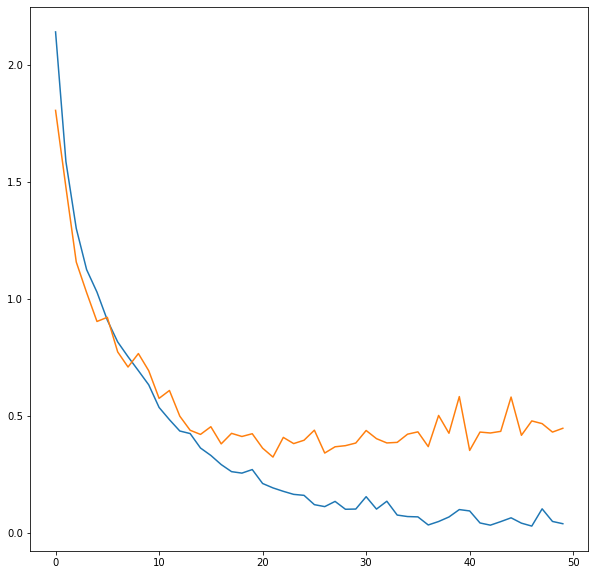

In [18]:
plt.figure(figsize=(10,10))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

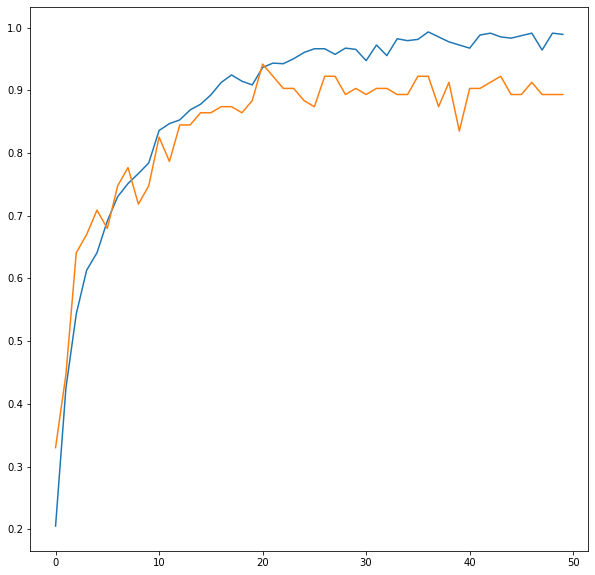

In [19]:
plt.figure(figsize=(10,10))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

In [25]:
model.evaluate(x_test, y_test_oh)

1/1 [==============================] - 0s 31ms/step - loss: 5.6529 - accuracy: 0.3500


[5.652939319610596, 0.3499999940395355]

In [26]:
pred = model.predict(x_test)

In [42]:
tr_li = []
fa_li = []
for i in range(len(pred)):
    if (np.argmax(pred[i]) == y_test_en[i]) == True:
        tr_li.append(x_test[i])
    else:
        fa_li.append(x_test[i])
    

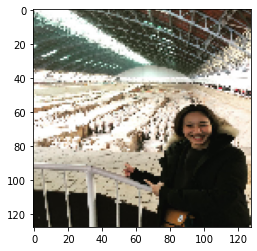

In [104]:
plt.imshow(tr_li[5])

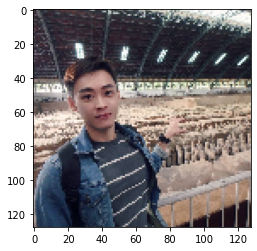

In [101]:
plt.imshow(fa_li[11])

In [9]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [10]:
model = ResNet50(weights=None, input_shape=(150,150,3), include_top=False, classes=47)

In [11]:
x = model.output
x = Flatten()(x)
#x = Dense(1028, activation='relu')(x)
#x = Dense(512, activation='relu')(x)

#x = Dense(100, activation='relu')(x)
predictions = Dense(47, activation='softmax')(x)

In [12]:
res_model = Model(inputs=model.input, outputs=predictions)
res_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']         

 conv2_block3_2_conv (Conv2D)   (None, 38, 38, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 38, 38, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 38, 38, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 38, 38, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 19, 19, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 19, 19, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 19, 19, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 19, 19, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_2_bn[0][0]']      
 n)       

 conv5_block2_1_conv (Conv2D)   (None, 5, 5, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 5, 5, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 5, 5, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 5, 5, 512)    2359808     ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_blo

In [13]:
res_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [ ]:
with tf.device('/GPU:0'):
    hist = res_model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=200,
        validation_data=validataion_generator,
        validation_steps=train_generator.samples//train_generator.batch_size
)

C:\Users\bitcamp\AppData\Local\Temp/ipykernel_6740/456776170.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = res_model.fit_generator(


Epoch 1/200


In [18]:
from tensorflow.keras.applications import VGG19

In [19]:
model = VGG19(weights=None, input_shape=(150,150,3), include_top=False, classes=47)

In [20]:
x = model.output
x = Flatten()(x)
predictions = Dense(47, activation='softmax')(x)

In [22]:
predictions

<KerasTensor: shape=(None, 47) dtype=float32 (created by layer 'dense_1')>

In [23]:
x = preprocess_input(x_train)

NameError: name 'x_train' is not defined

In [143]:
preds = model.predict(x)

In [146]:
preds

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ...,

In [145]:
print('Predicted:', decode_predictions(preds, top=3)[0])

ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (1005, 4, 4, 2048)

In [28]:
pre_model = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3), classes=47)

In [29]:
x = pre_model.output
x = Flatten()(x)
predictions = Dense(47, activation='softmax')(x)

In [30]:
model = Model(inputs=pre_model.input, outputs=predictions)

In [31]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [32]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [33]:
with tf.device('/GPU:0'):
    hist = model.fit_generator(
        train_generator,
        steps_per_epoch=20,
        epochs=200,
        validation_data=validataion_generator,
        validation_steps=10,
)

Epoch 1/200


C:\Users\bitcamp\AppData\Local\Temp/ipykernel_5732/1770143513.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


ResourceExhaustedError: Graph execution error:

Detected at node 'model_2/block1_conv2/Conv2D' defined at (most recent call last):
    File "C:\Users\bitcamp\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\bitcamp\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\bitcamp\anaconda3\lib\asyncio\base_events.py", line 596, in run_forever
      self._run_once()
    File "C:\Users\bitcamp\anaconda3\lib\asyncio\base_events.py", line 1890, in _run_once
      handle._run()
    File "C:\Users\bitcamp\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
      await result
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2901, in run_cell
      result = self._run_cell(
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2947, in _run_cell
      return runner(coro)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3172, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3364, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\bitcamp\AppData\Local\Temp/ipykernel_5732/1770143513.py", line 2, in <module>
      hist = model.fit_generator(
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\training.py", line 2209, in fit_generator
      return self.fit(
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\layers\convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "C:\Users\bitcamp\anaconda3\lib\site-packages\keras\layers\convolutional.py", line 233, in convolution_op
      return tf.nn.convolution(
Node: 'model_2/block1_conv2/Conv2D'
OOM when allocating tensor with shape[30,64,150,150] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_2/block1_conv2/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_15875]